**Формулировка задачи:**

Даны данные об обращении застрахованных по ДМС в лечебные учреждения за 2021 год с указанием даты обращения, количества полученных медицинских услуг и их суммарной стоимости. Кроме того, доступна информация о поле и возрасте пациентов. Требуется обучить модель предсказания факта обращения застрахованного в январе 2022. Т.е., требуется классифицировать застрахованных на 2 класса: 1 - застрахованный обратился в январе 2022 года, 0 - застрахованный не обратился в январе 22 года

**Доступные данные:**

Данные можно скачать по [ссылке](https://disk.yandex.ru/d/BG0gpuBcYlbUEw)

- insured - уникальный ид застрахованного лица
- service_date - дата оказания услуги
- service_count - количество оказанных услуг
- service_amount - суммарная цена оказанных услуг
- sex_id - пол застрахованного
- age_for_service_date - возраст застрахованного на дату оказания услуги

## 1 Изучение данных из файла

In [ ]:
pip install sweetviz

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, roc_auc_score, roc_curve, recall_score
from sklearn.dummy import DummyClassifier
import sweetviz as sv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%matplotlib inline

In [ ]:
data = pd.read_csv('/content/sample_data/MainsLab_data_DS_22.csv')
data

,insured,service_date,sex_id,age_for_service_date,serv_count,serv_amount
0,125045,2021-03-03,1.0,6,2.0,2260.00
1,125045,2021-04-11,1.0,6,1.0,1600.00
2,125045,2021-04-18,1.0,6,5.0,4510.00
3,125045,2021-04-23,1.0,6,1.0,380.00
4,125045,2021-06-09,1.0,6,1.0,2500.00
...,...,...,...,...,...,...
764328,1226064,2022-01-13,2.0,29,1.0,950.00
764329,1226064,2022-01-25,2.0,29,5.0,1501.00
764330,1226064,2022-01-26,2.0,29,2.0,427.50
764331,1226151,2022-01-10,2.0,58,1.0,950.00


                                             |          | [  0%]   00:00 -> (? left)


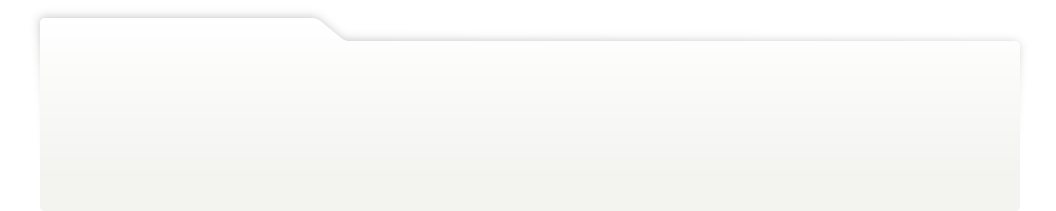
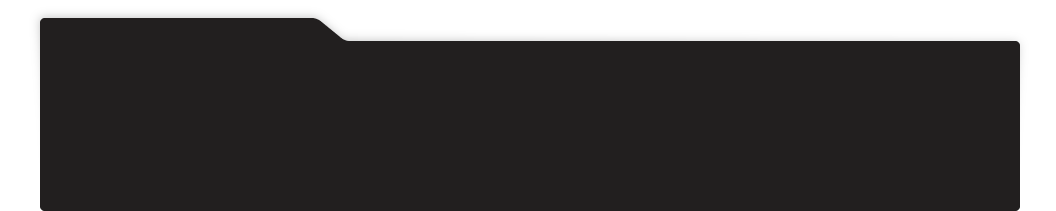
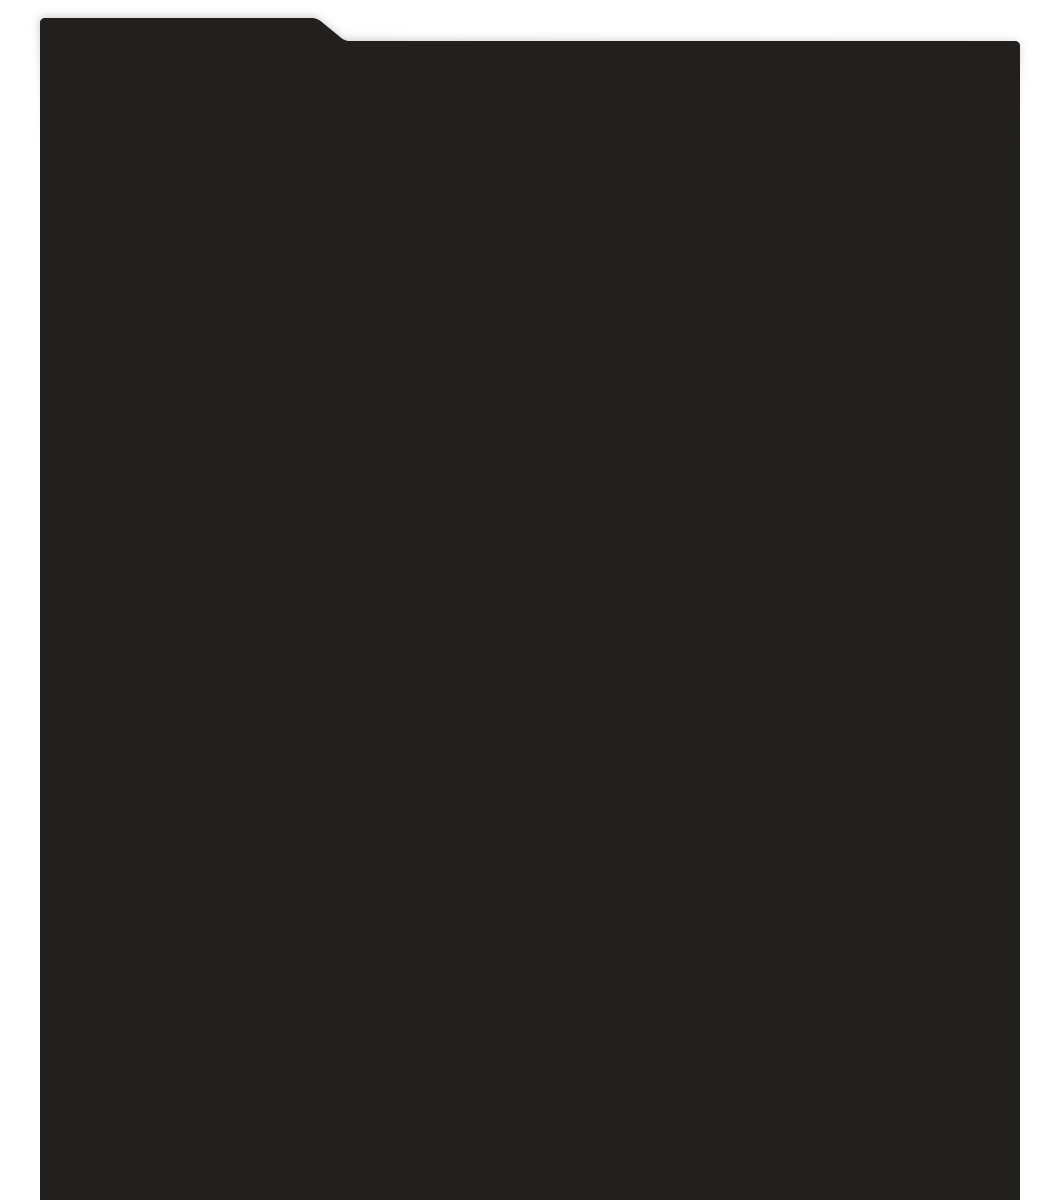
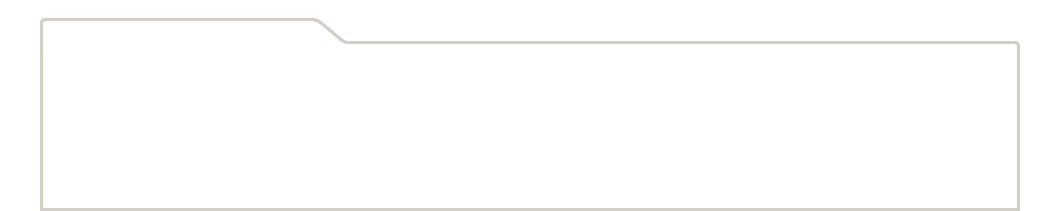
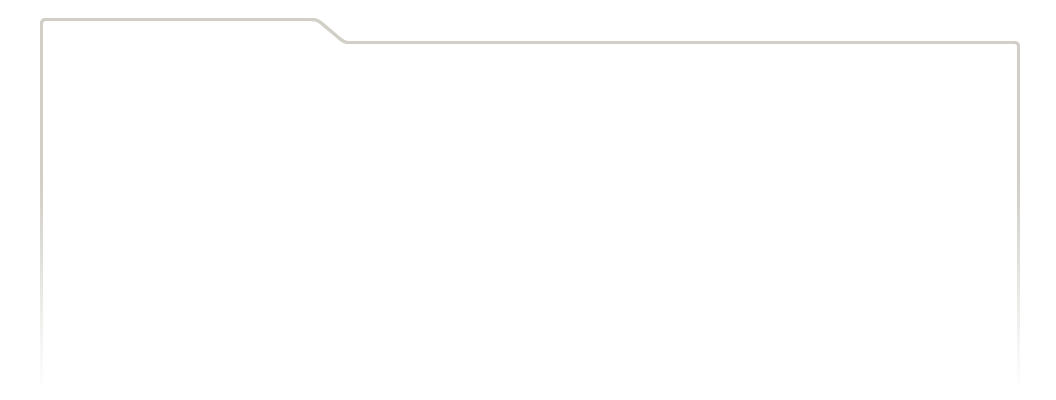
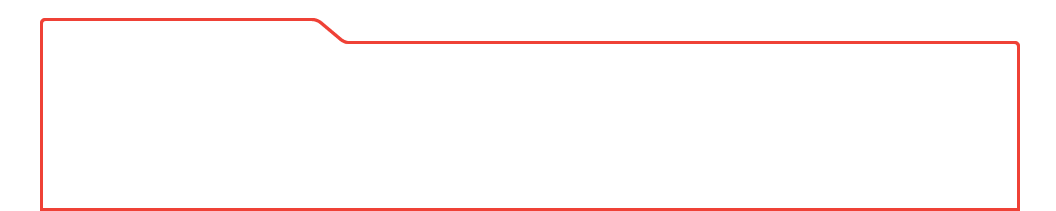
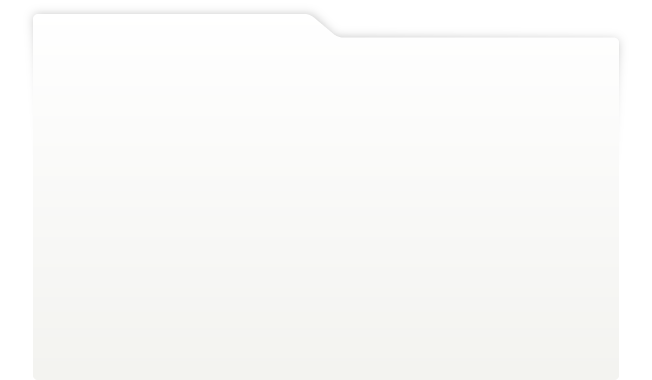
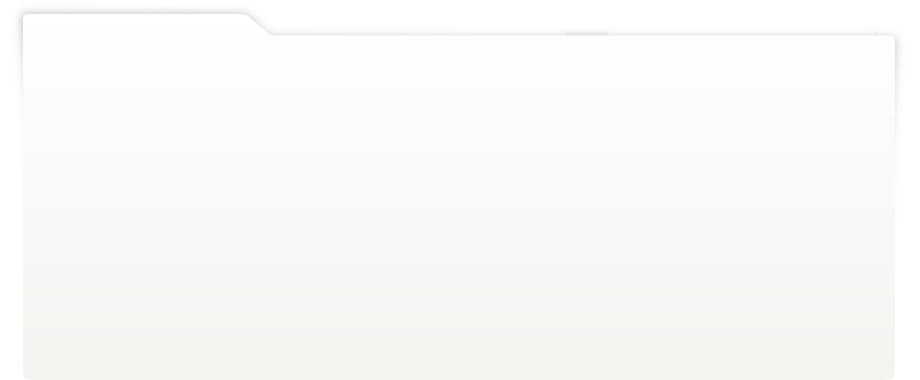
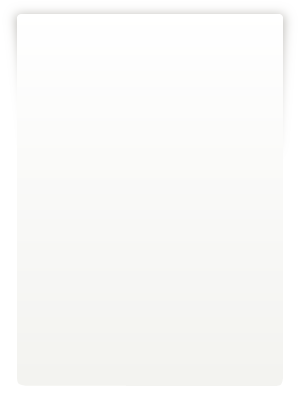
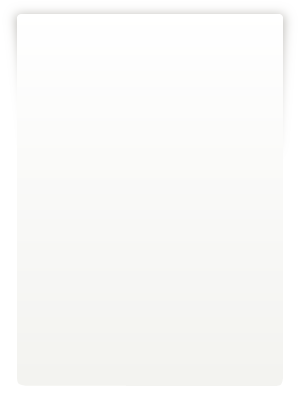
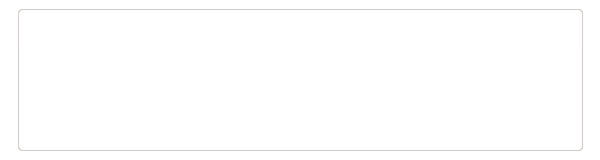
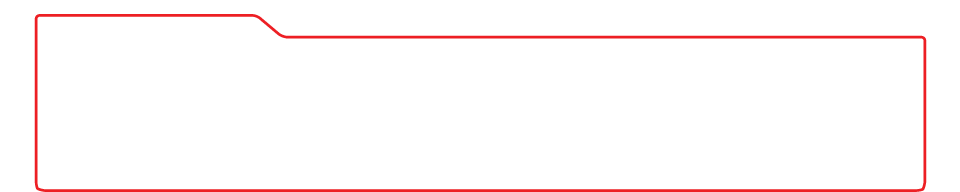
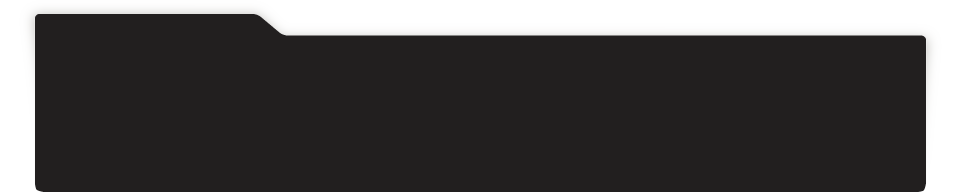
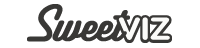
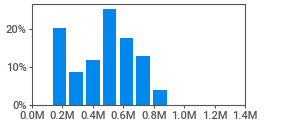
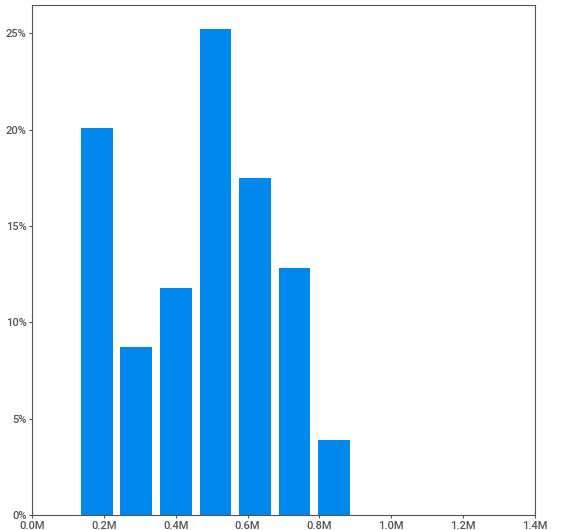
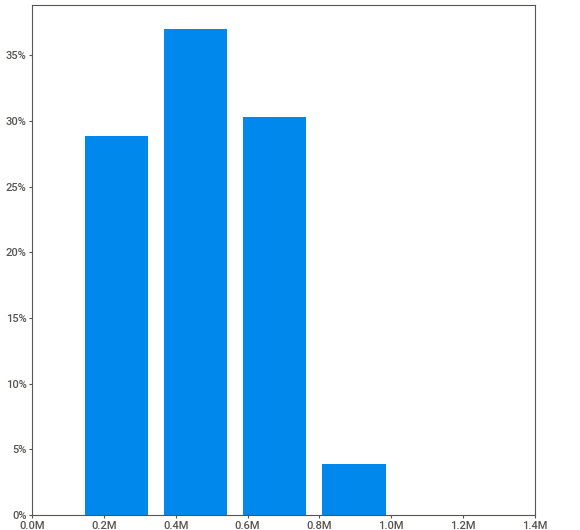
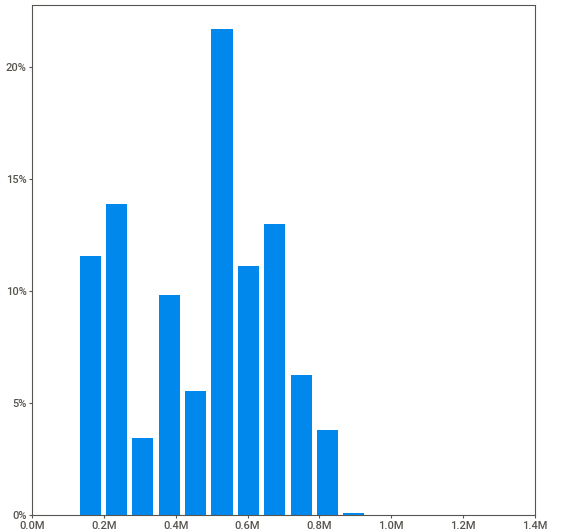
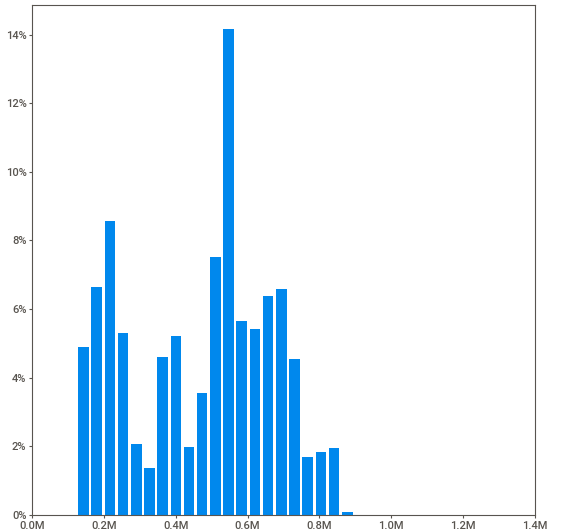
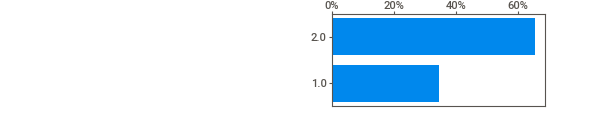
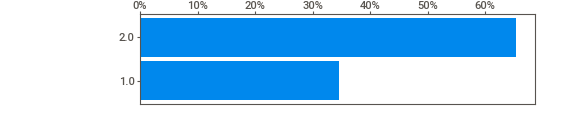
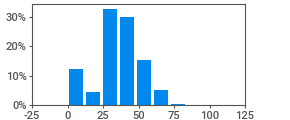
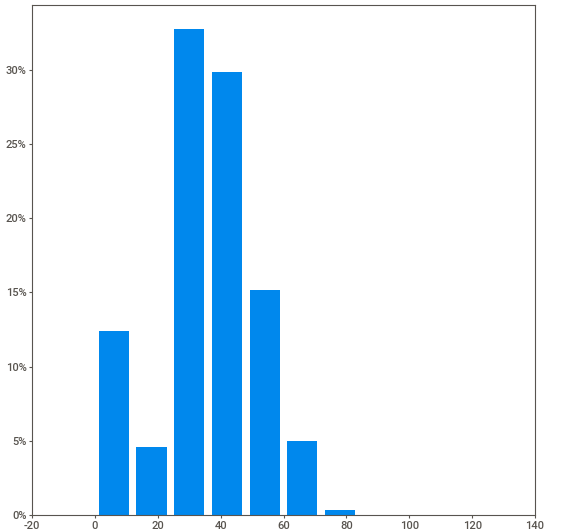
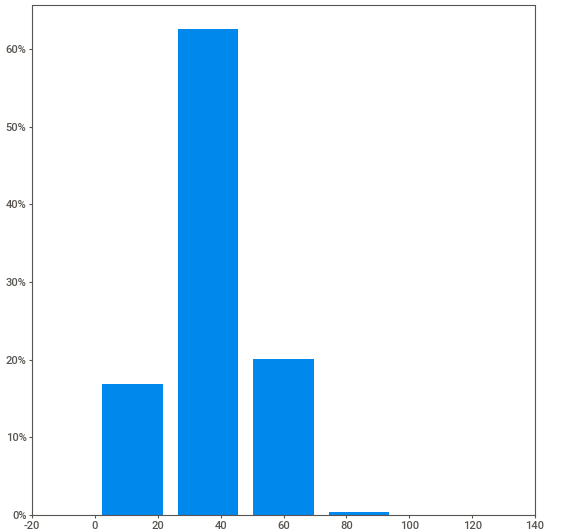
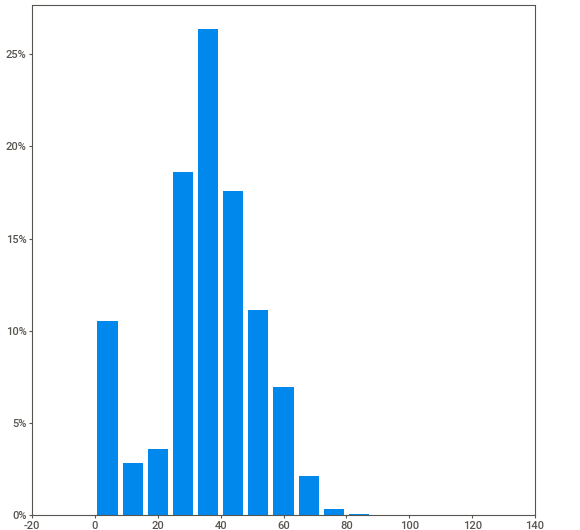
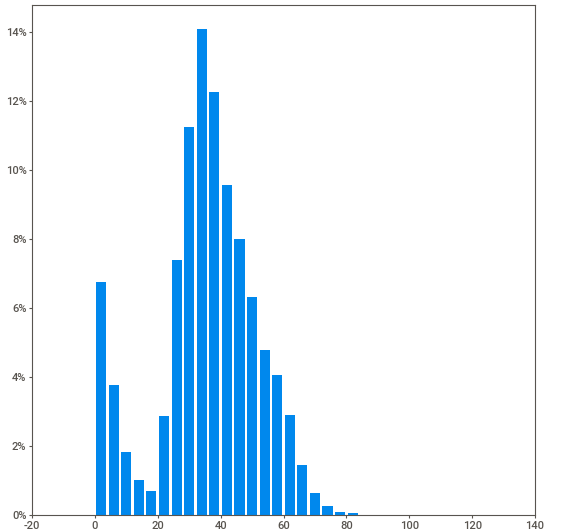
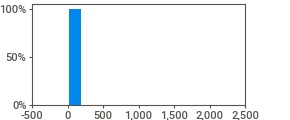
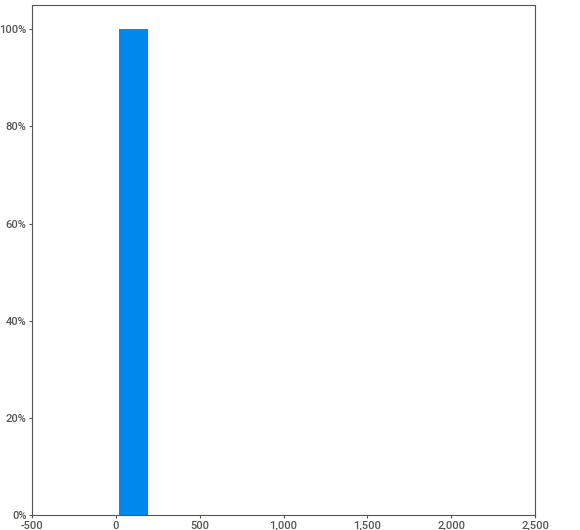
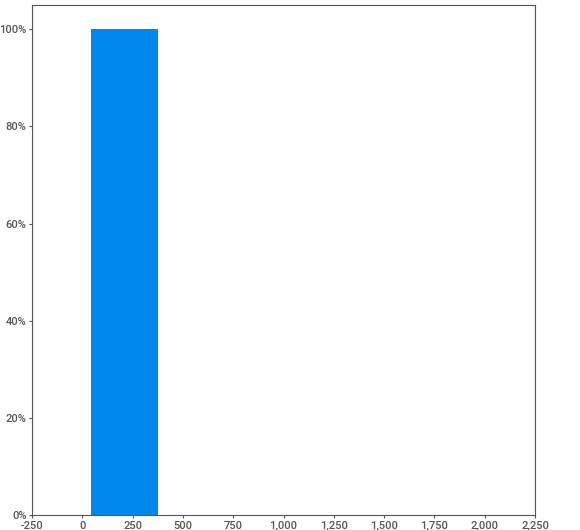
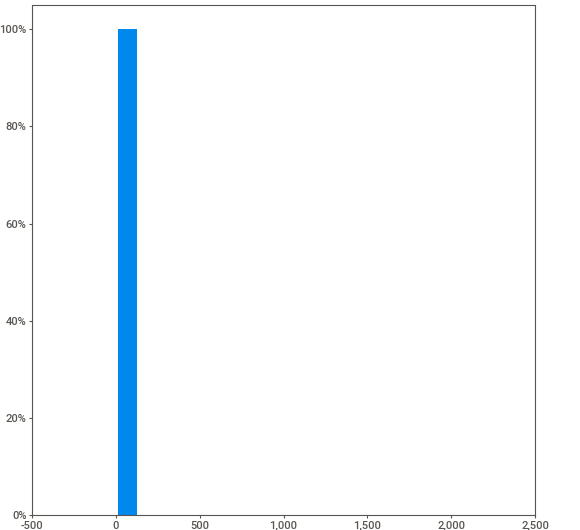
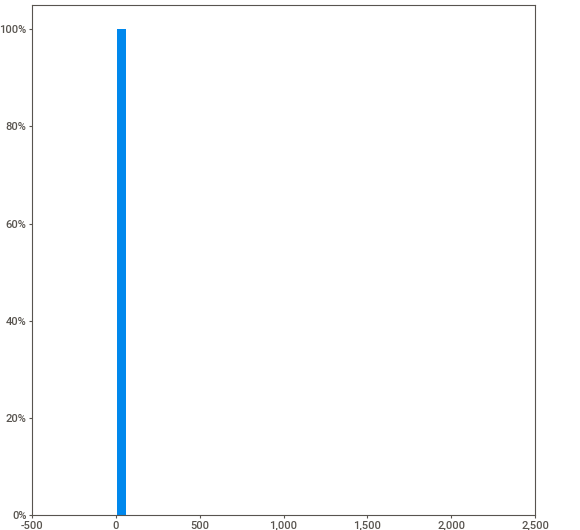
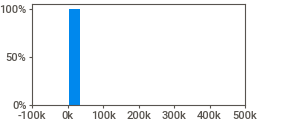
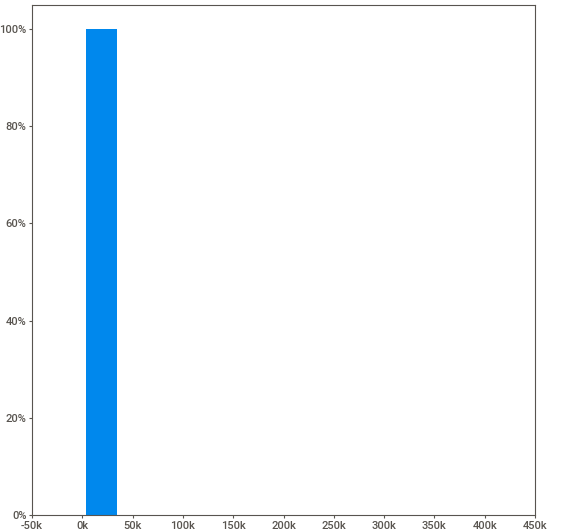
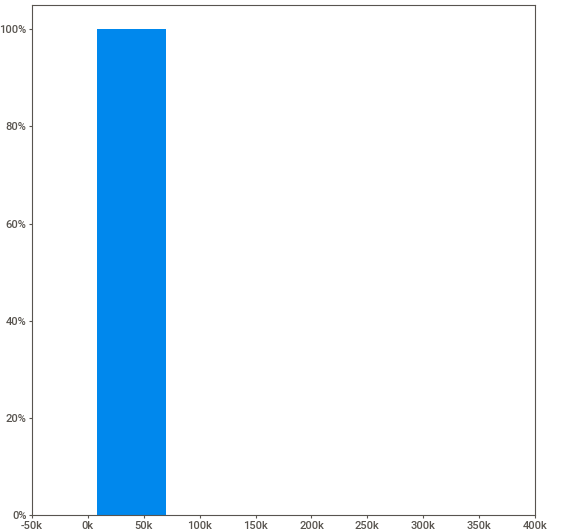
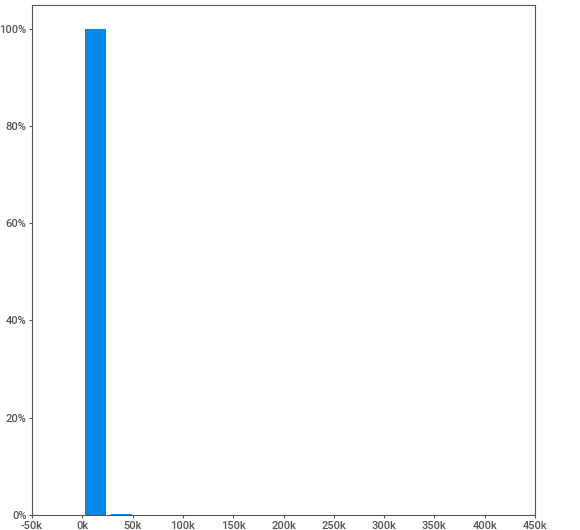
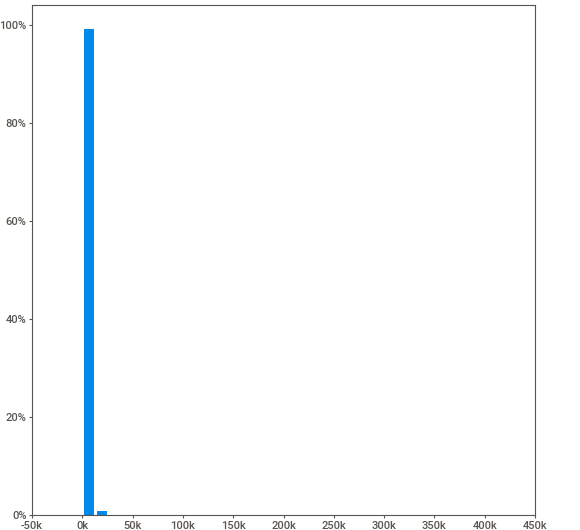
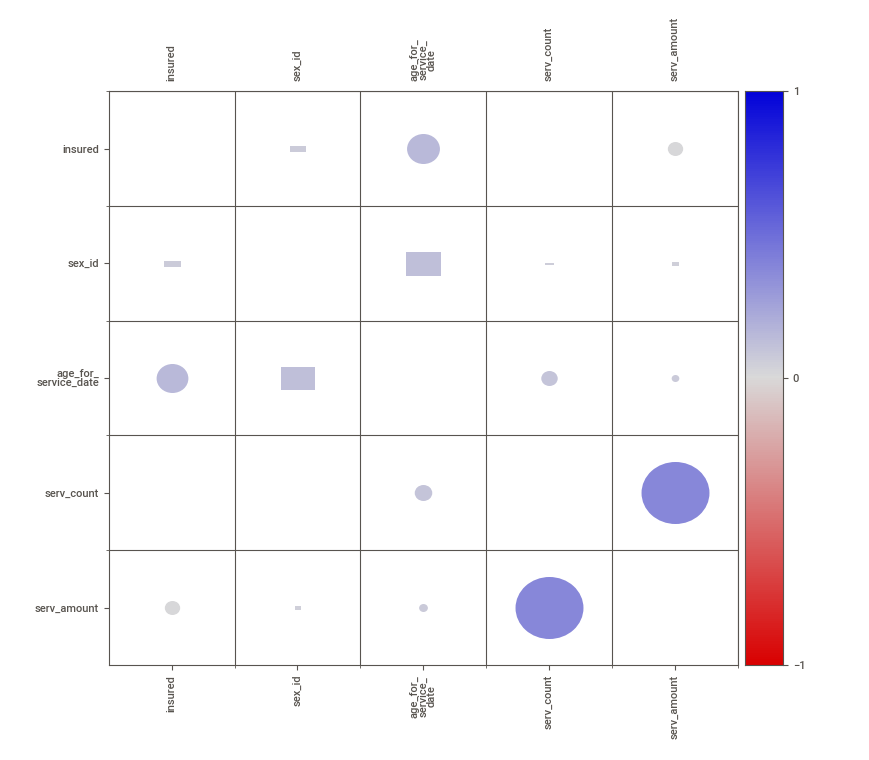
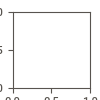

In [ ]:
sv.analyze(data).show_notebook()

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 764333 entries, 0 to 764332
Data columns (total 6 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   insured               764333 non-null  int64  
 1   service_date          764333 non-null  object 
 2   sex_id                764129 non-null  float64
 3   age_for_service_date  764333 non-null  int64  
 4   serv_count            764333 non-null  float64
 5   serv_amount           764333 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 35.0+ MB


### 1.1 Вывод

- В датасете 764333 строк и 6 столбцов 
- корреляция между serv_count и serv_amount
- 204 пропуска в столбце sex_id
- 52 дубликата
- всплеск в 0 в столбце age_for_service_date
- Колонки с типом float нужно привести к целочисленному типу данных int, колонку service_date к формату date

## 2 Предобработка данных





In [ ]:
#Удалим дупликаты
df = data.drop_duplicates().reset_index(drop=True)

In [ ]:
#Удалим пропуски
df = df.dropna().reset_index(drop=True)

In [ ]:
#Приведём столбцы в нужный формат
df['service_date'] = pd.to_datetime(df['service_date'], format = '%Y-%m-%d')
df['sex_id'] = df['sex_id'].astype('int64')
df['serv_count'] = df['serv_count'].astype('int64')

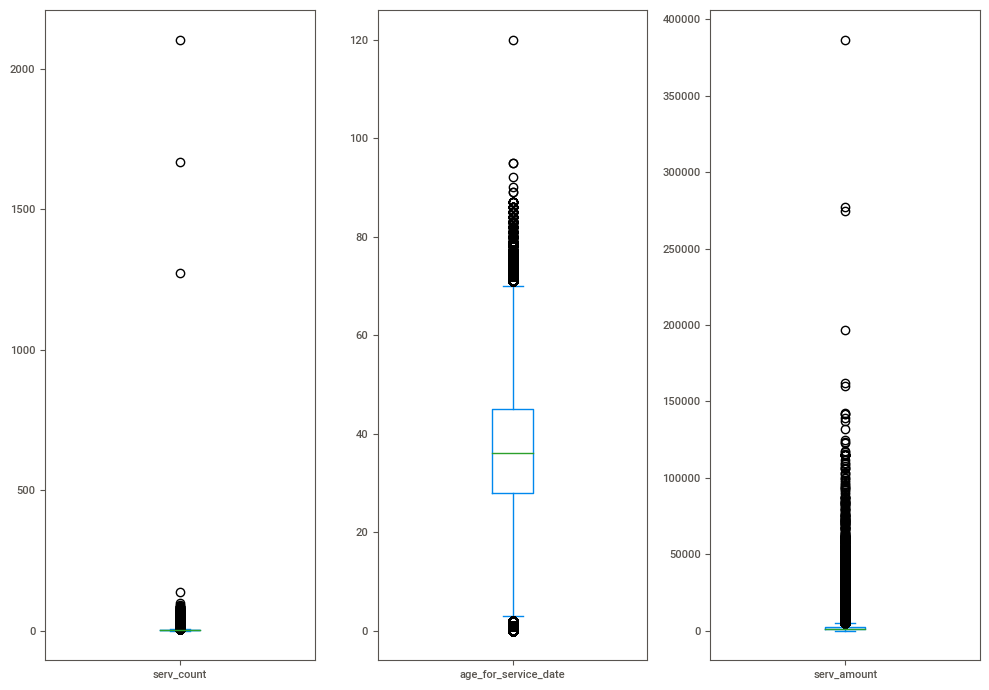

<Figure size 1400x800 with 0 Axes>

In [ ]:
#Построим графики диаграммы размаха
fig, axes = plt.subplots(nrows = 1, ncols =3, figsize=(10,7) )
plt.figure(figsize=(14,8))
df['serv_count'].plot(ax=axes[0], kind='box')
df['age_for_service_date'].plot(ax=axes[1], kind='box')
df['serv_amount'].plot(ax=axes[2], kind='box')
fig.tight_layout();

In [ ]:
print('После предобработки удалено строк:', len(data) - len(df))

После предобработки удалено строк: 256


In [ ]:
# Добавим столбцы года, месяца и дня
df['year'] = df['service_date'].dt.year
df['month'] = df['service_date'].dt.month
df['day'] = df['service_date'].dt.day

### 2.1 EDA

In [ ]:
#Сгруппируем средний чек и сумму чеков по месяцу и году
payments = pd.pivot_table(data = df, index = ['year', 'month'], values = ['serv_amount'], aggfunc = ['sum', 'mean']).rename(columns={'serv_amount': '', 
                                                                                         'serv_amount': ''}).reset_index()

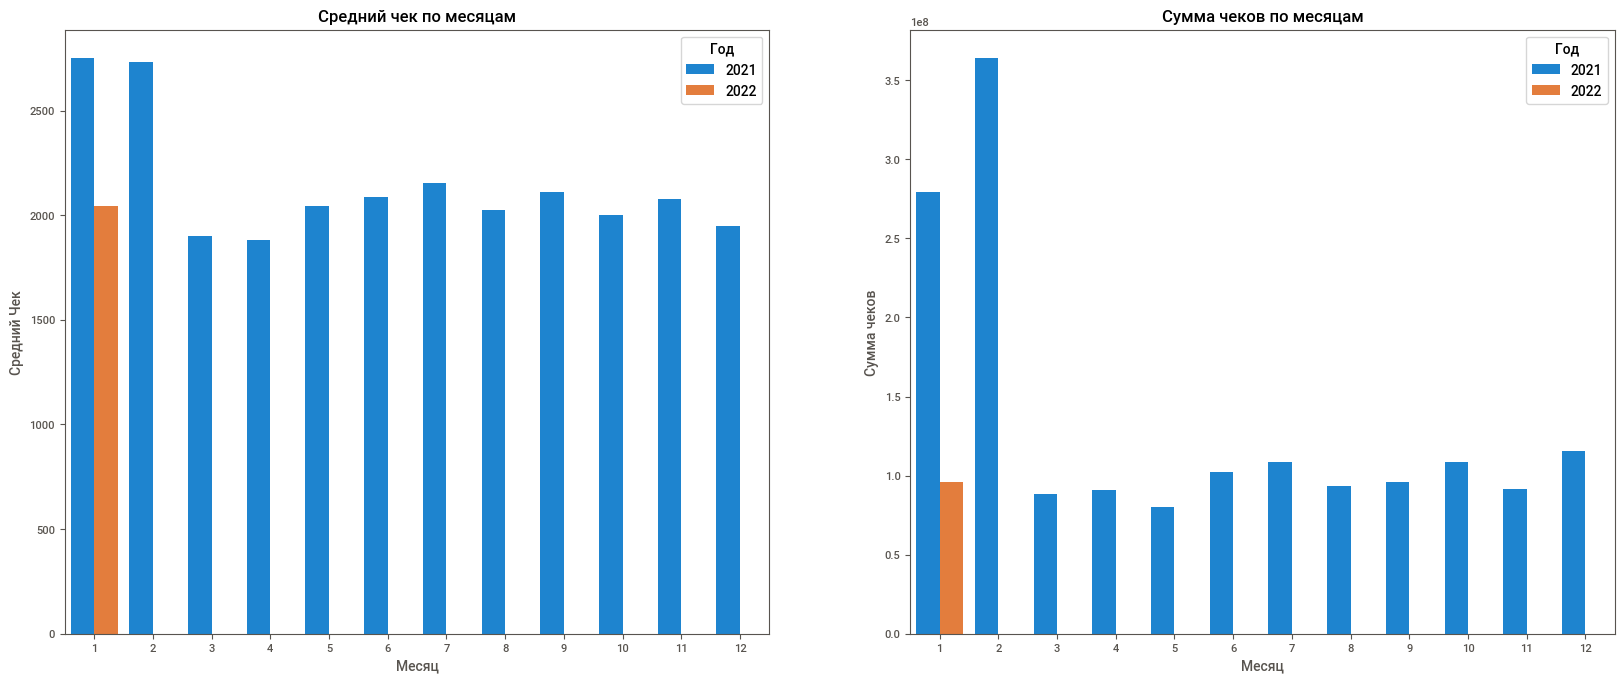

In [ ]:
#Графики чеков
fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(20,8))
sns.barplot(data = payments, x = 'month', y ='mean', hue = 'year', ax = axes[0])
sns.barplot(data = payments, x = 'month', y ='sum', hue = 'year', ax = axes[1])
axes[0].legend(loc='upper right', title = 'Год')
axes[1].legend(loc='upper right', title = 'Год')
axes[0].set(xlabel ='Месяц', ylabel = 'Средний Чек', title = 'Средний чек по месяцам')
axes[1].set(xlabel ='Месяц', ylabel = 'Сумма чеков', title = 'Сумма чеков по месяцам');

In [ ]:
#Сгруппируем сумму обращений и количество оказанных услуг
uslugi = pd.pivot_table(data = df, index = ['year', 'month'], values = ['serv_count'], aggfunc = ['count', 'sum']).rename(columns={'serv_count': '', 
                                                                                         'serv_count': ''}).reset_index()

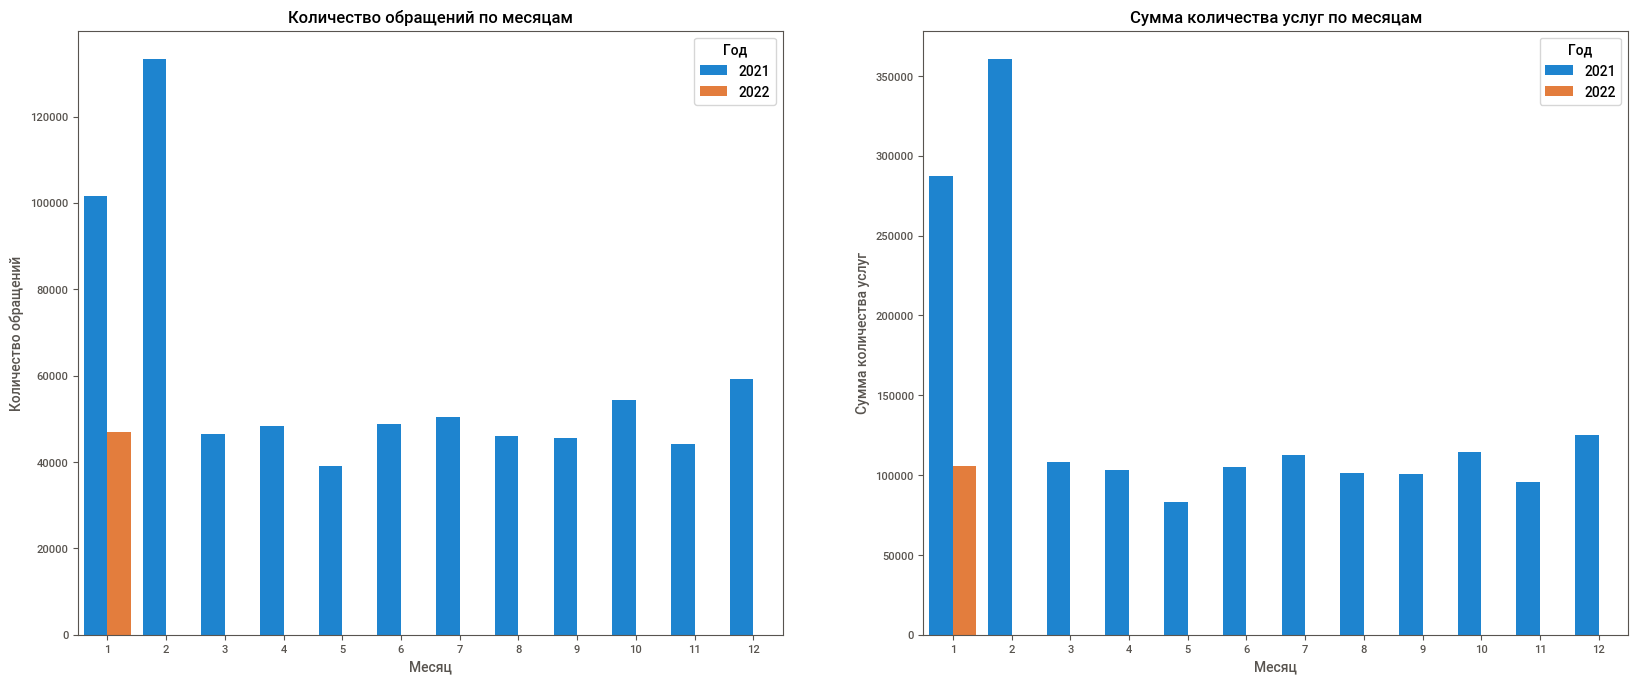

In [ ]:
#График услуг
fig, axes = plt.subplots(nrows = 1, ncols =2, figsize=(20,8))
sns.barplot(data = uslugi, x = 'month', y ='count', hue = 'year', ax = axes[0])
sns.barplot(data = uslugi, x = 'month', y ='sum', hue = 'year', ax = axes[1])
axes[0].legend(loc='upper right', title = 'Год')
axes[1].legend(loc='upper right', title = 'Год')
axes[0].set(xlabel ='Месяц', ylabel = 'Количество обращений', title = 'Количество обращений по месяцам')
axes[1].set(xlabel ='Месяц', ylabel = 'Сумма количества услуг', title = 'Сумма количества услуг по месяцам');

### 2.2 Добавление целевого признака

In [ ]:
#Создадим функцию для создания колонки с целевым признаком
def test(s):
  if s == 2022:
    return 1
  else:
    return 0

In [ ]:
#Сгруппируем по клиенту и оставим последюю дату посещения
grouped = df.groupby('insured')['year'].max().reset_index()

In [ ]:
#Создадим колонку с целевым признаком
grouped['class'] = grouped['year'].apply(test)

In [ ]:
grouped = grouped.drop('year', axis = 1)

In [ ]:
#Присоединим колонку с целевым признаком к основным данным
df = df.merge(grouped, on ='insured', how= 'left')

Уберем данные за 22 год и не будем использовать их, так как мы предсказываем для 22 года - фактически утечка данных, он по столбцу year сделает идеальный классификатор. То есть данные за 22 год только для таргета

In [ ]:
#Создадим даные только за 2021
df_2021 = df[df['year'] != 2022].drop(['year', 'service_date'], axis = 1)

Сделаем 12 столбцов по количеству месяцев и для каждого клиента ставим в столбец число - количество его обращений в этом месяце

In [ ]:
months = pd.pivot_table(data=df_2021, index = 'insured', columns = 'month', values = 'serv_count', aggfunc = 'count').fillna(0).reset_index()

In [ ]:
months = months.astype('int64')

In [ ]:
#Присоединим фрейм с месяцами к основному датасету
df_2021 = df_2021.merge(months, on ='insured', how= 'left').drop(['month', 'day'], axis = 1)

In [ ]:
#Посчитаем сумму услуг и сумму потраченных денег для каждого клиента
new = df_2021.groupby('insured').agg({'serv_amount': ['sum'], 'serv_count' : ['sum']}).reset_index()

In [ ]:
new.columns = ['insured', 'serv_count_sum', 'serv_amount_sum']

In [ ]:
#Соединим все в финальный датасет
full = df_2021.merge(new, how = 'left', on = 'insured').drop(['serv_count',	'serv_amount'], axis =1).groupby('insured').max().reset_index().astype('int')

In [ ]:
full.head()

,insured,sex_id,age_for_service_date,class,1,2,3,4,5,6,7,8,9,10,11,12,serv_count_sum,serv_amount_sum
0,125045,1,7,1,0,0,1,3,0,1,0,0,0,0,1,0,15350,12
1,125046,2,29,0,0,0,0,0,0,3,0,0,0,3,4,2,44840,43
2,125047,2,53,0,0,0,0,0,0,1,0,0,0,0,0,0,7060,8
3,125048,1,18,1,0,2,1,0,7,3,2,4,0,4,5,5,136710,119
4,125049,1,1,0,6,0,0,0,0,0,0,0,0,0,0,0,20301,21


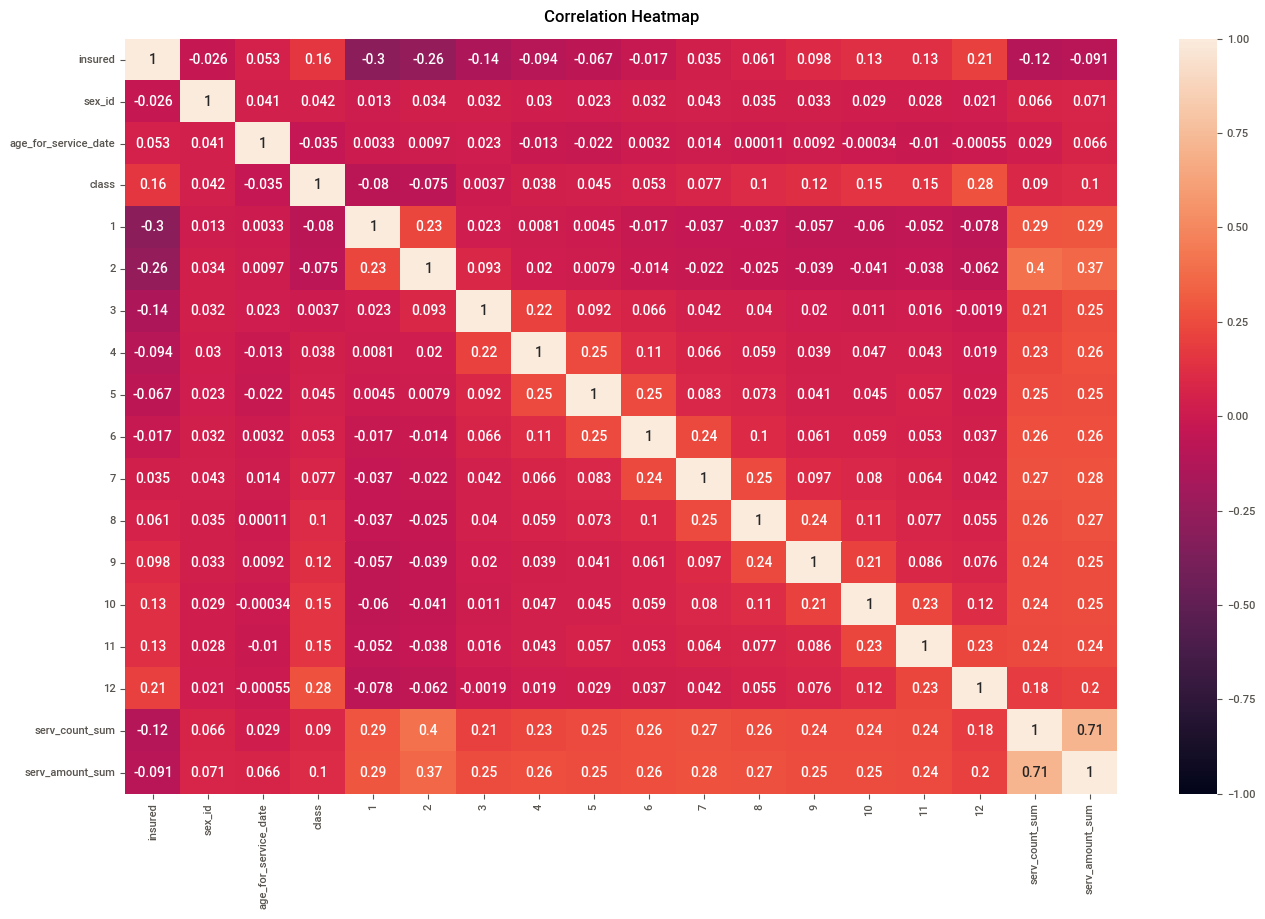

In [ ]:
#График корреляции признаков
plt.figure(figsize=(16, 10))
heatmap = sns.heatmap(full.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

                                             |          | [  0%]   00:00 -> (? left)


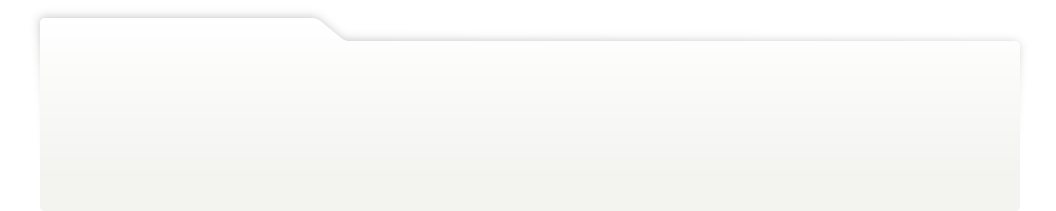
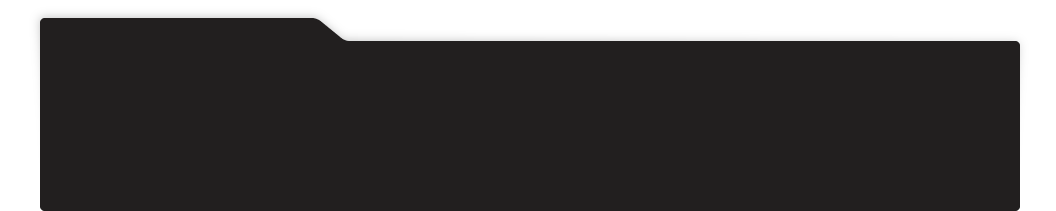
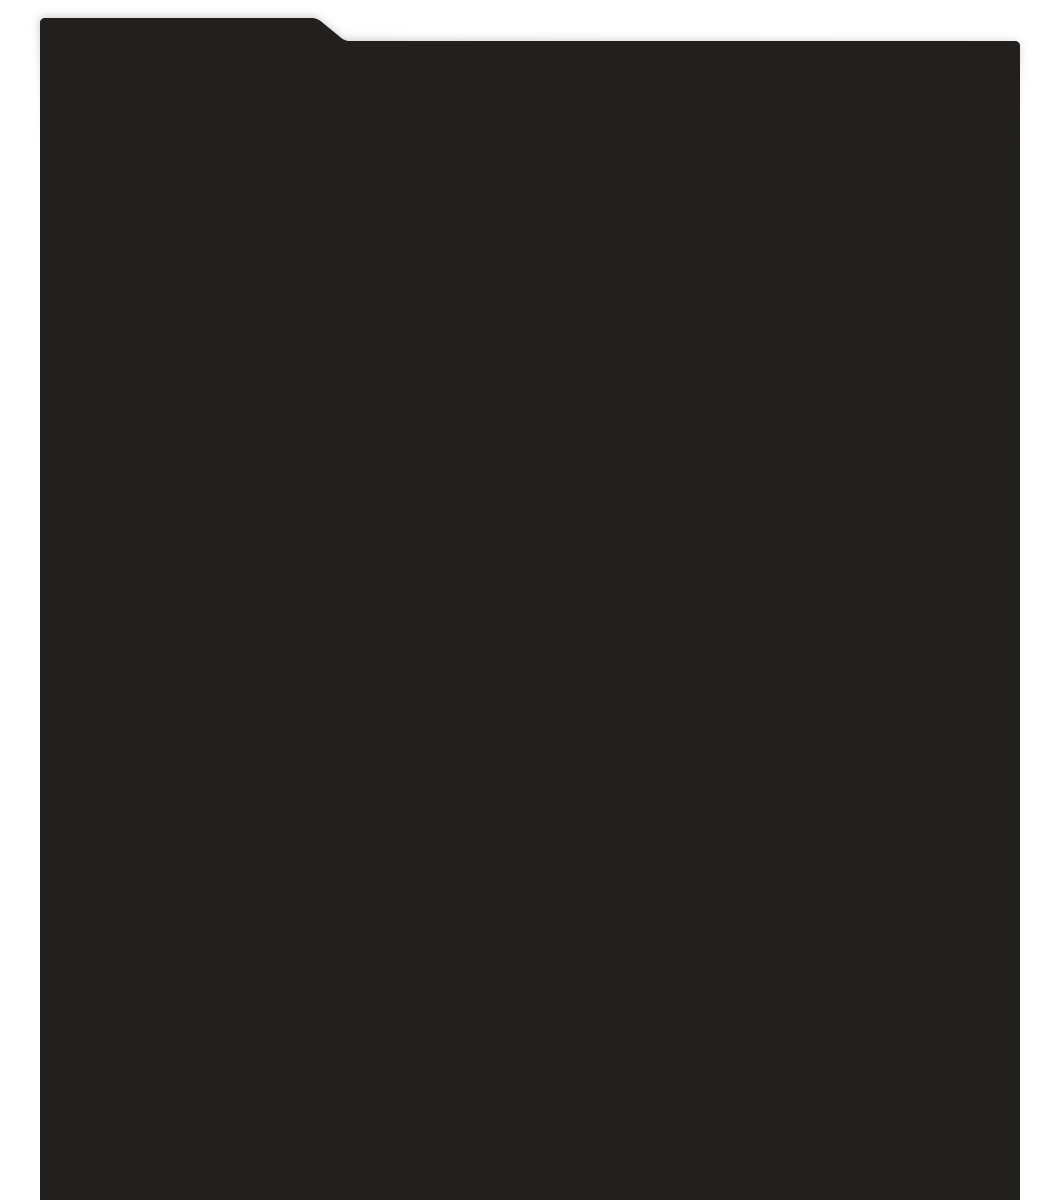
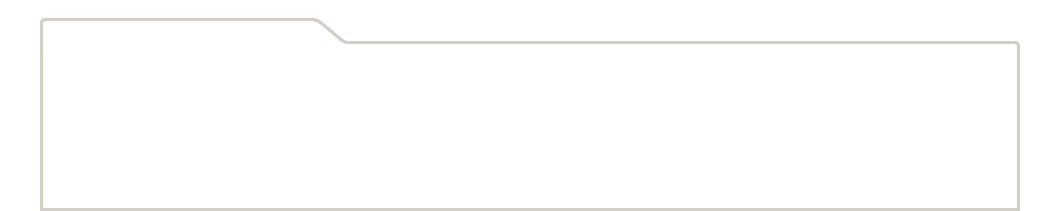
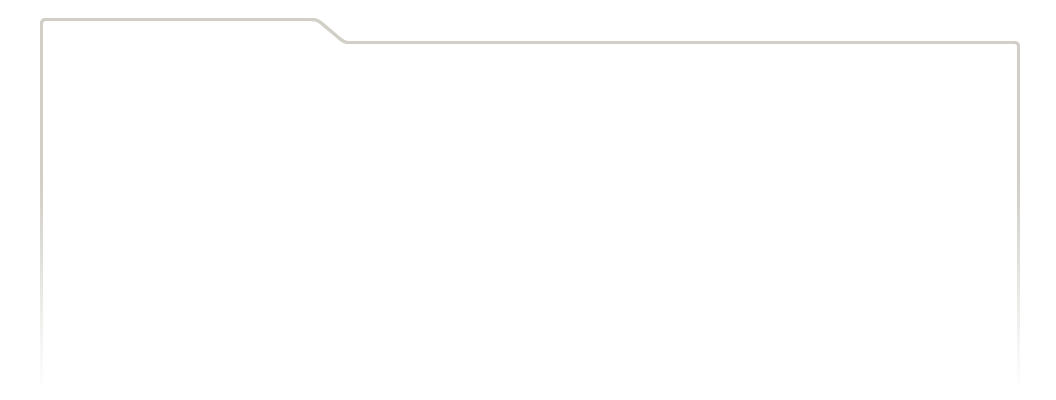
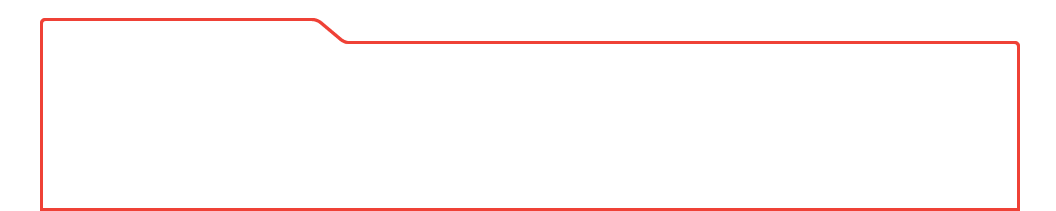
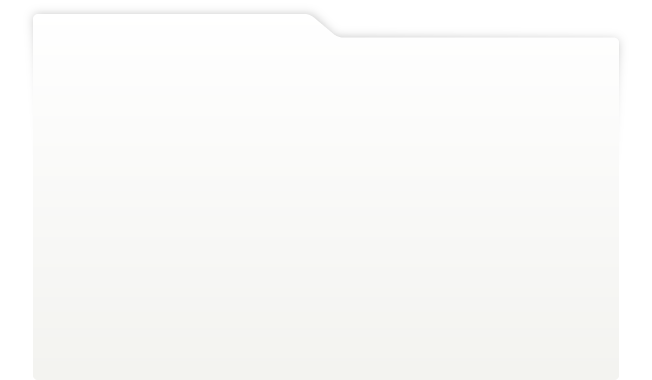
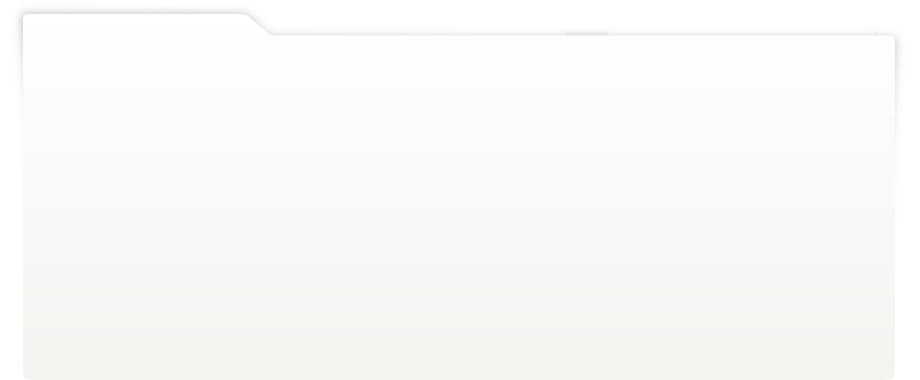
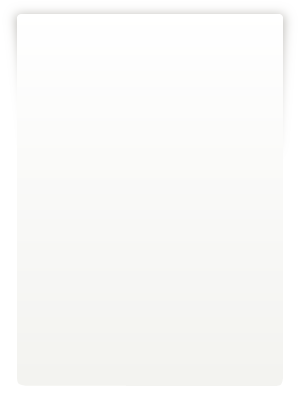
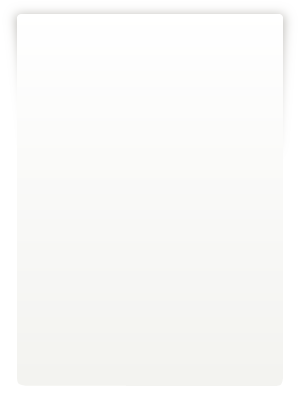
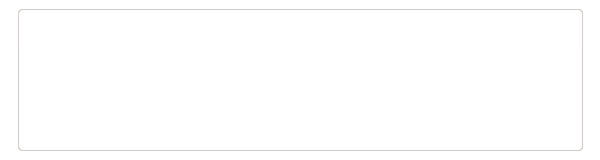
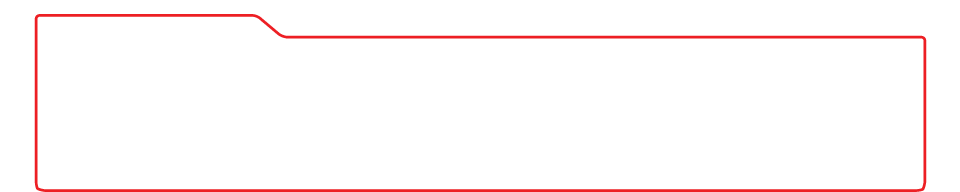
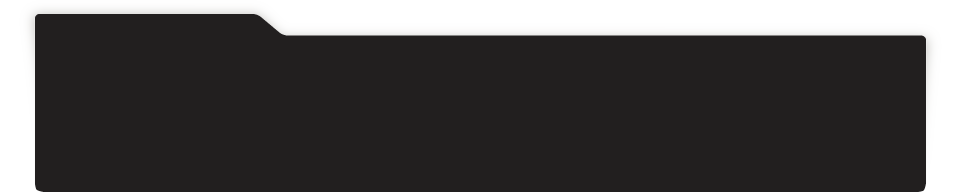
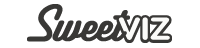
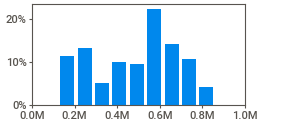
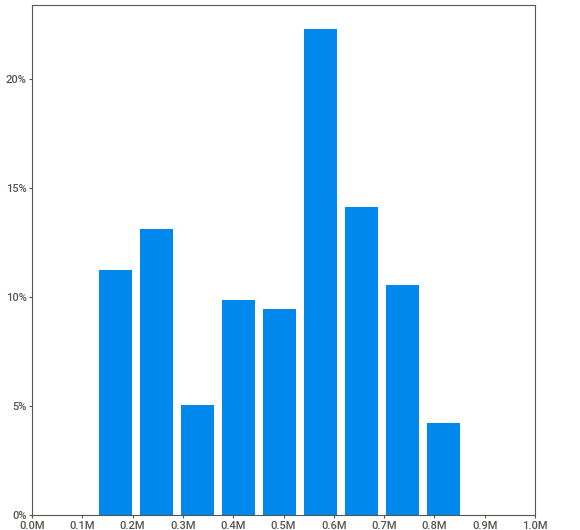
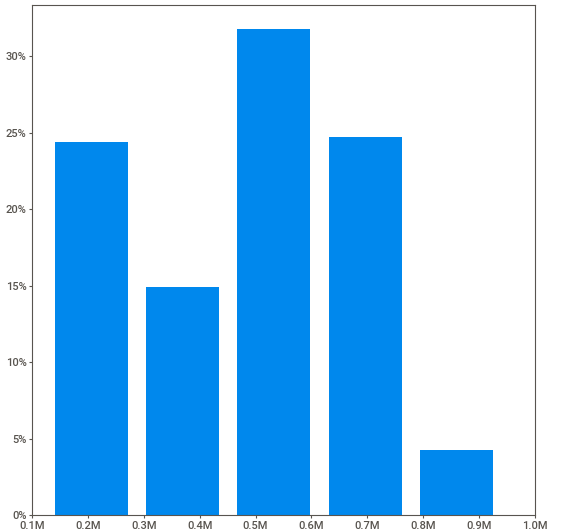
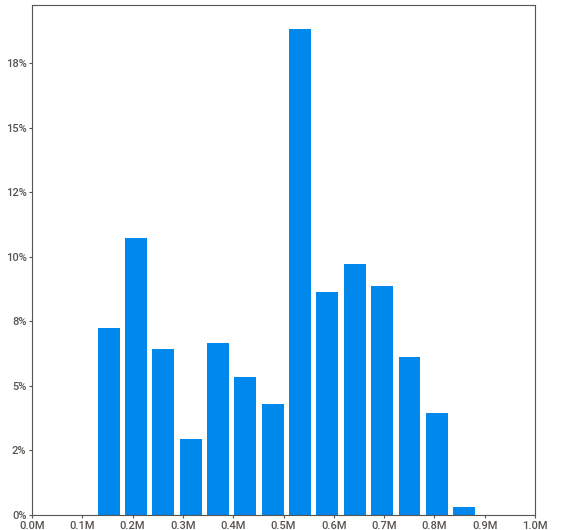
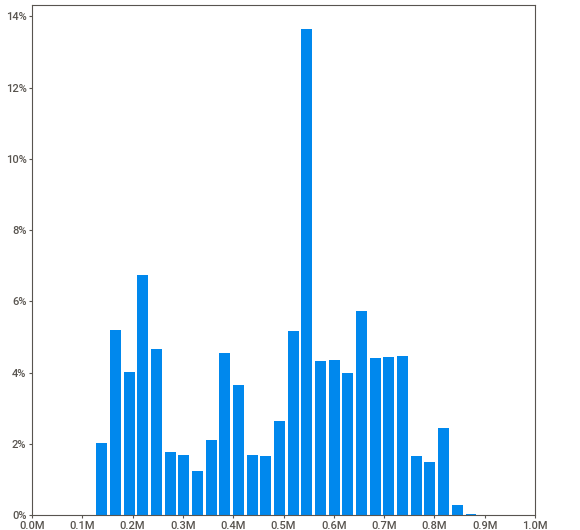
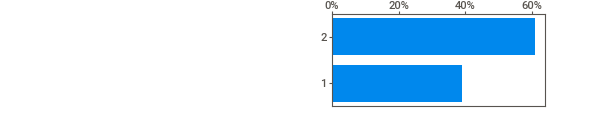
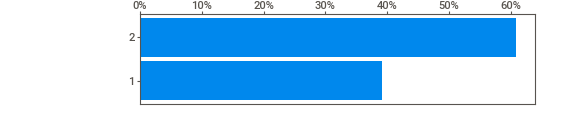
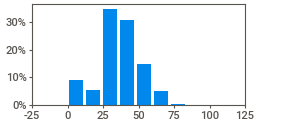
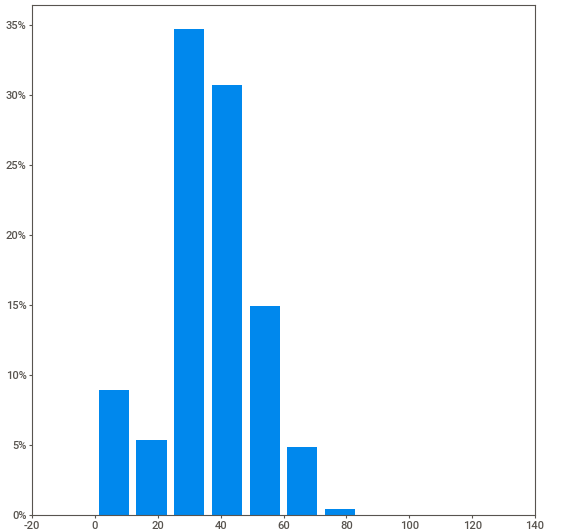
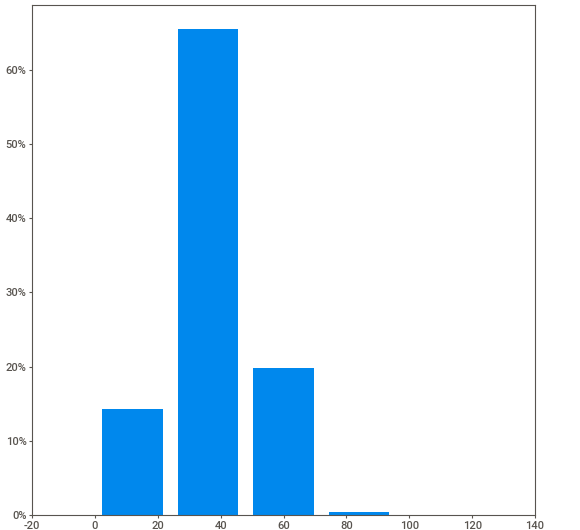
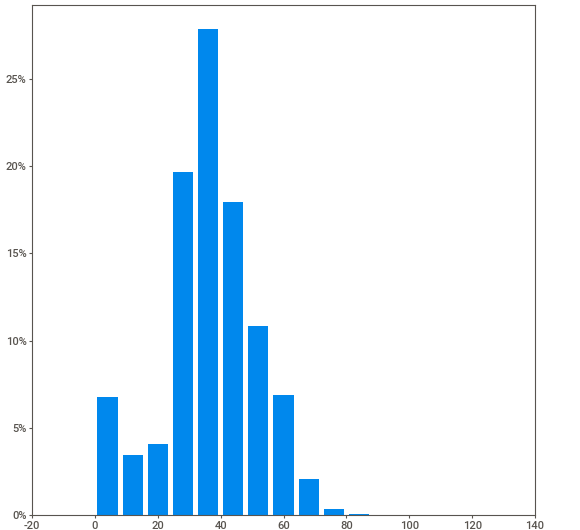
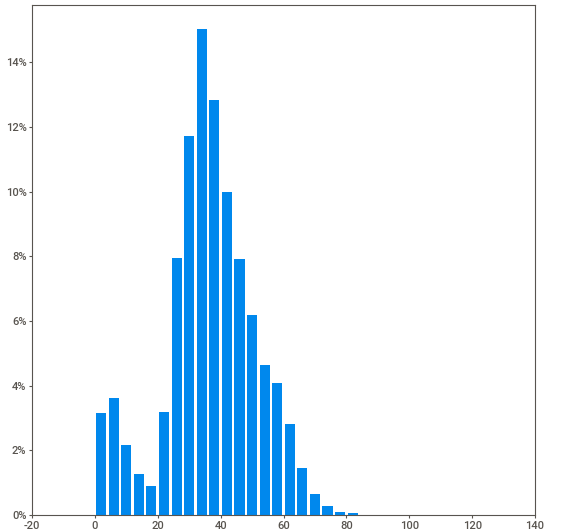
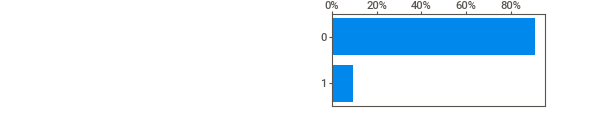
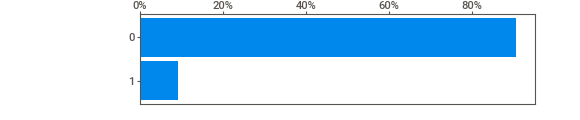
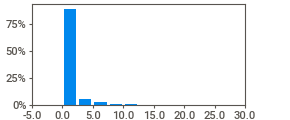
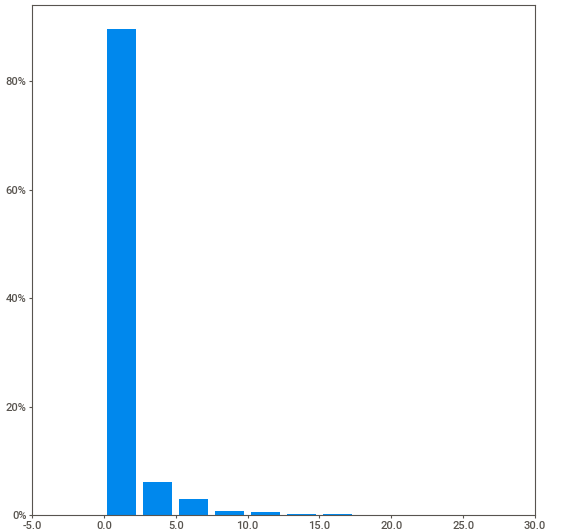
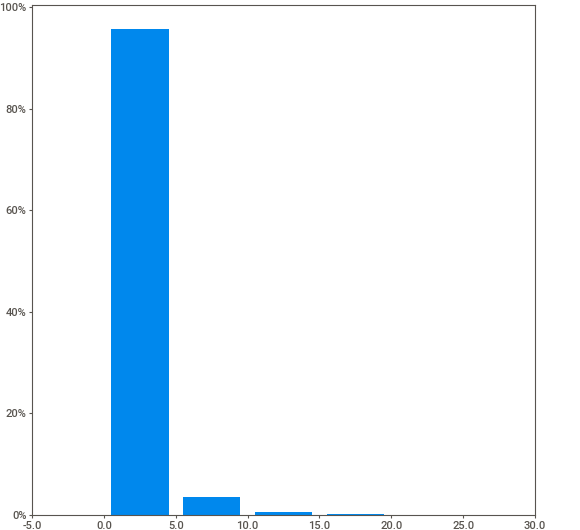
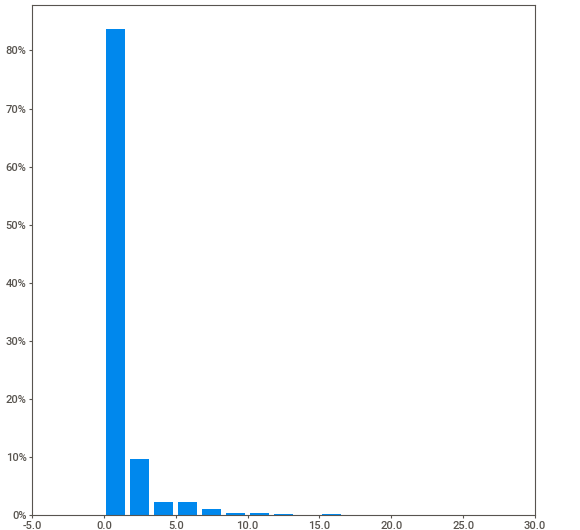
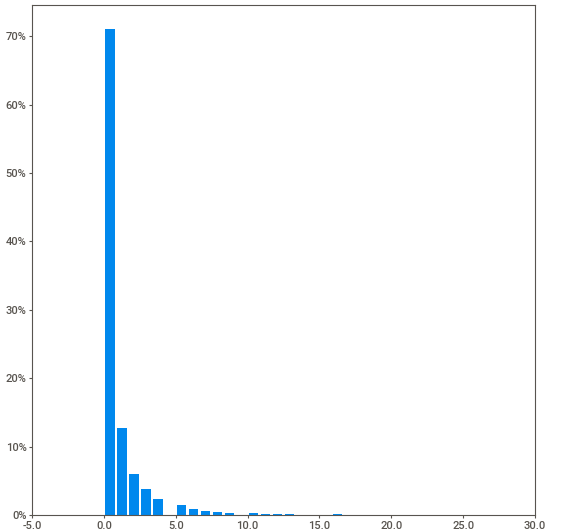
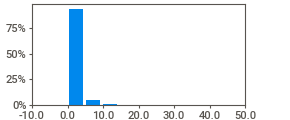
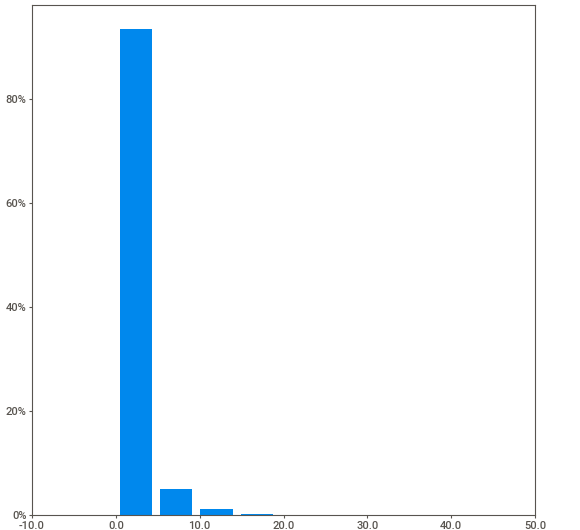
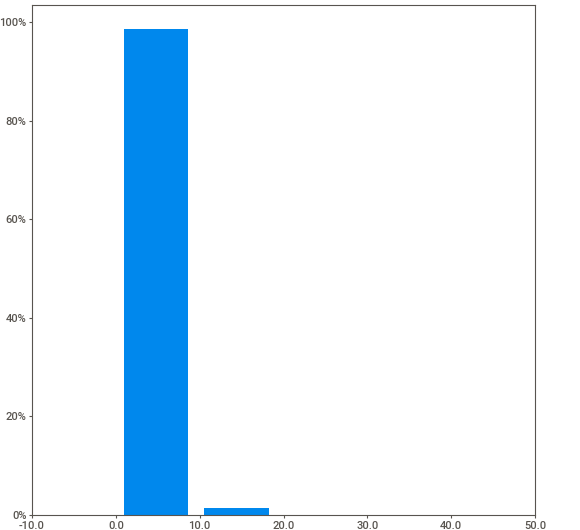
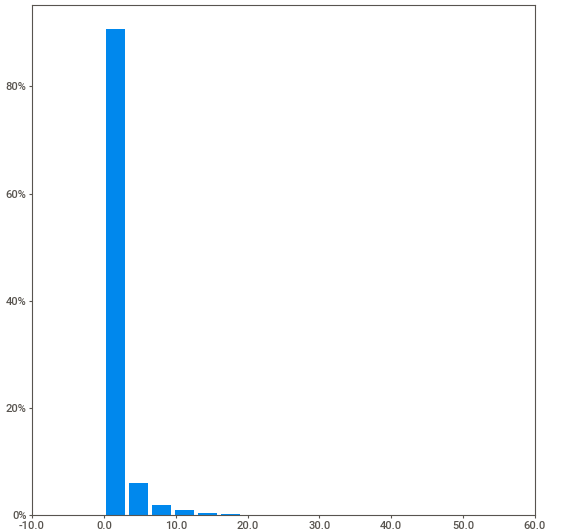
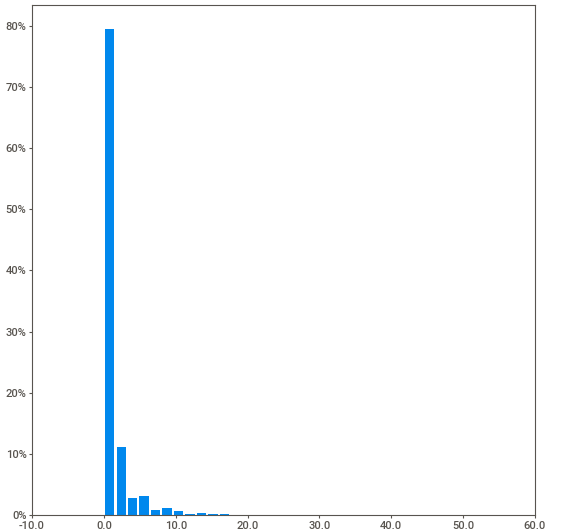
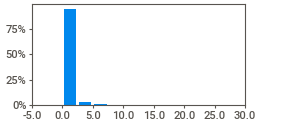
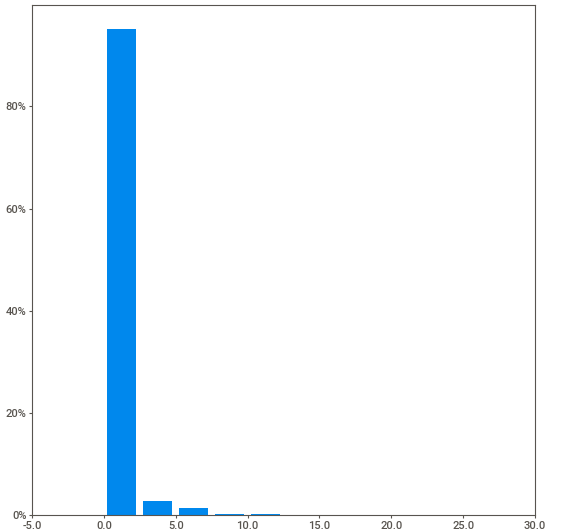
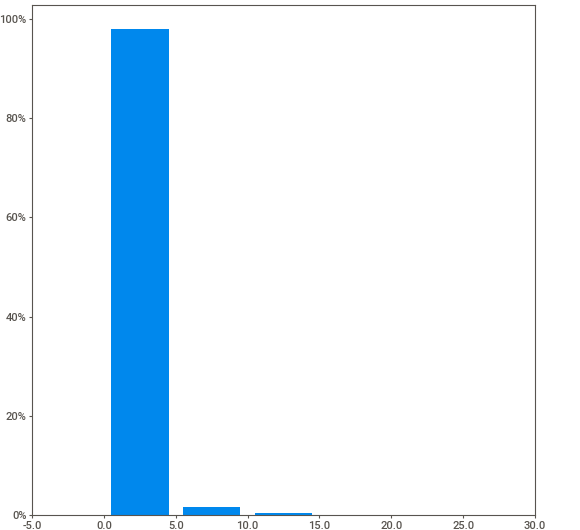
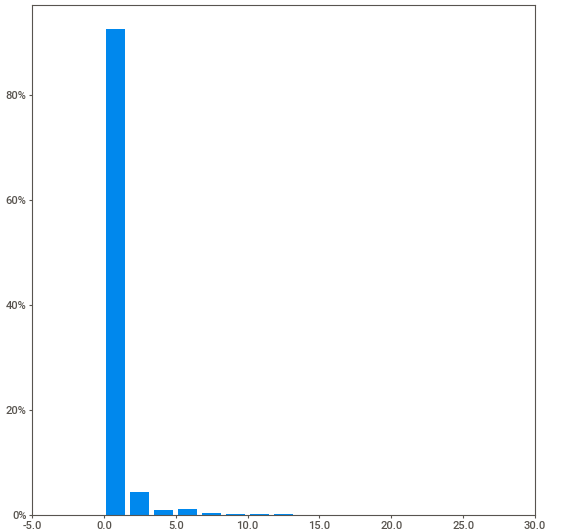
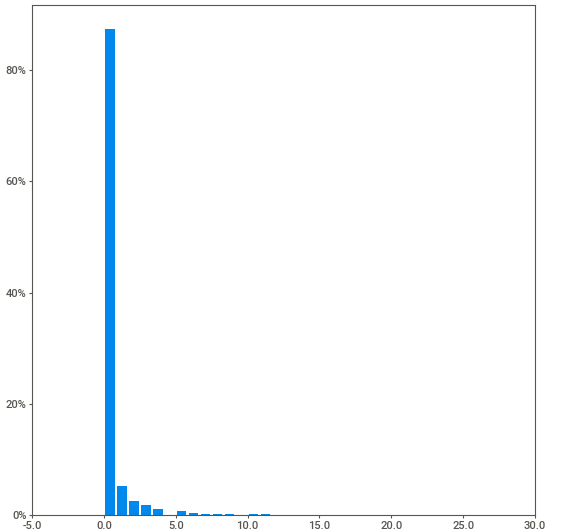
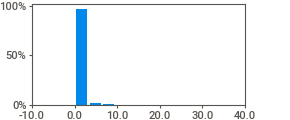
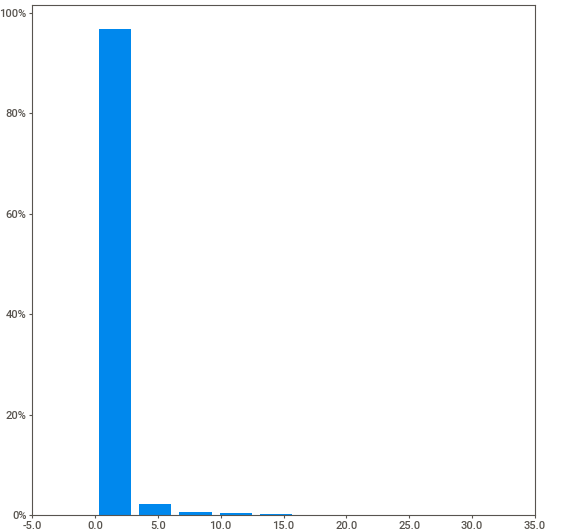
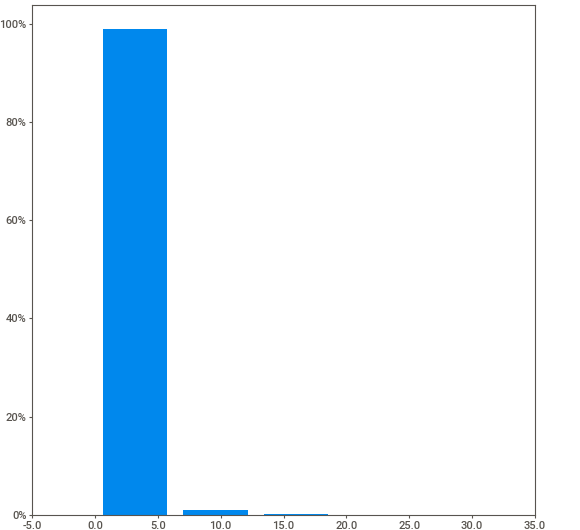
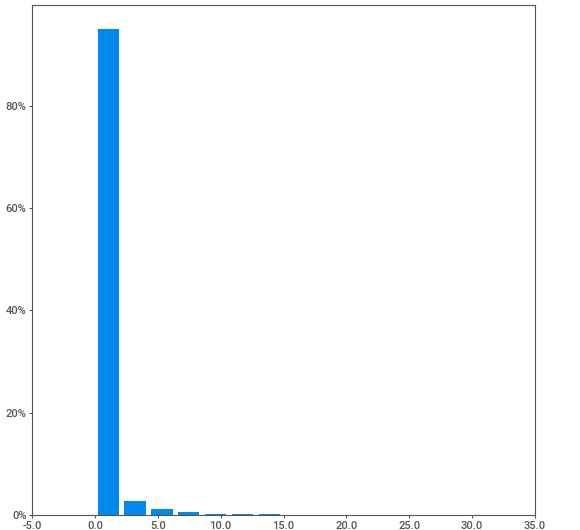
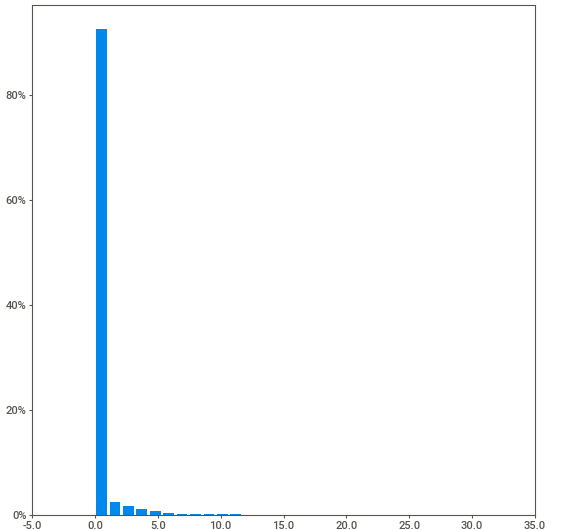
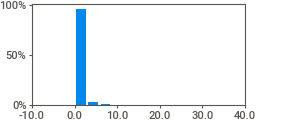
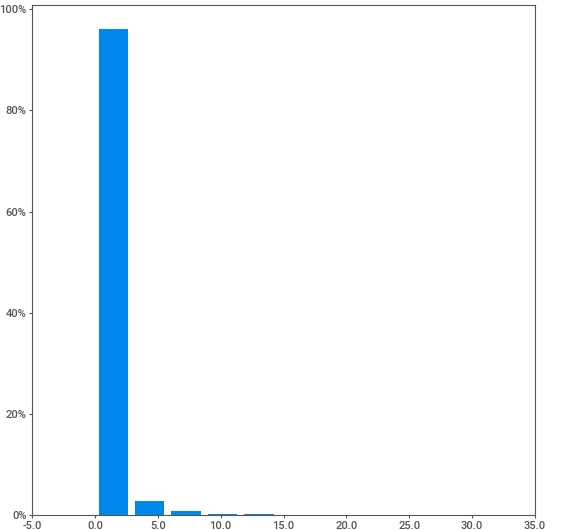
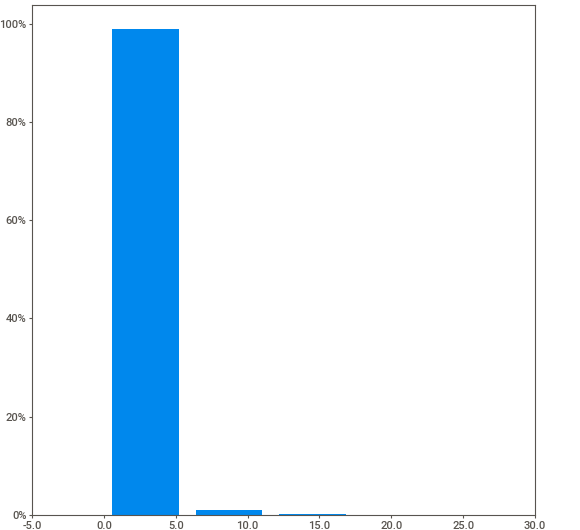
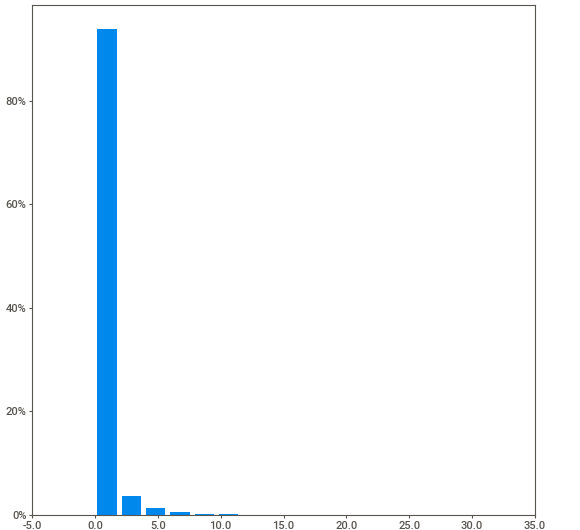
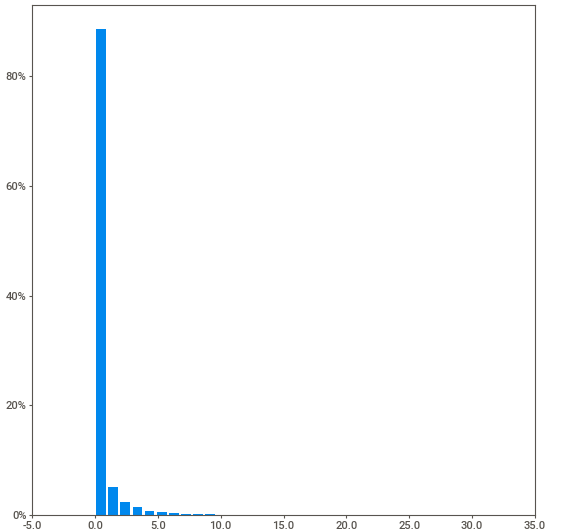
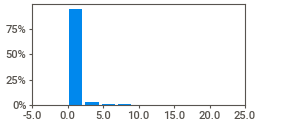
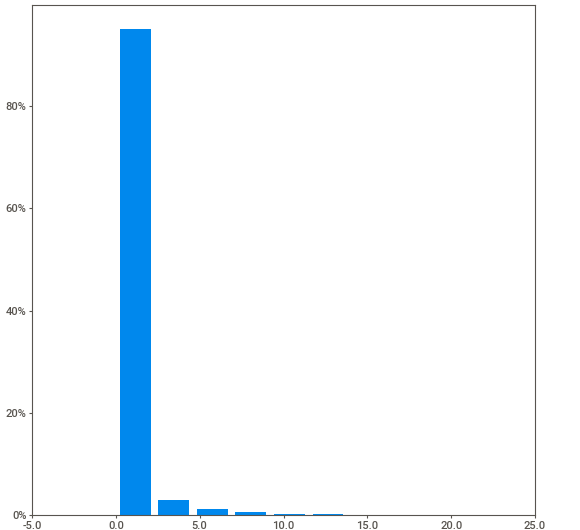
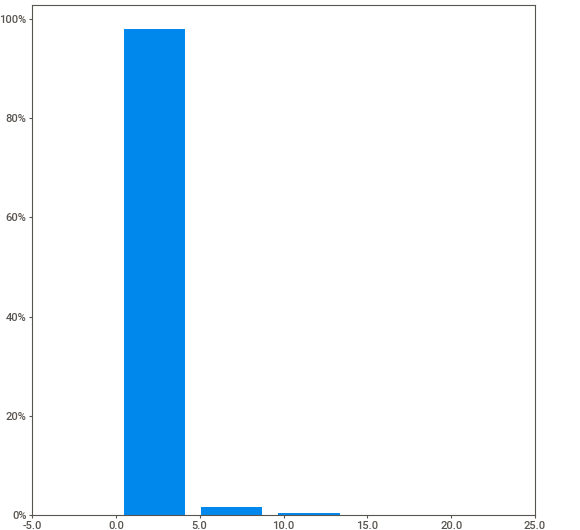
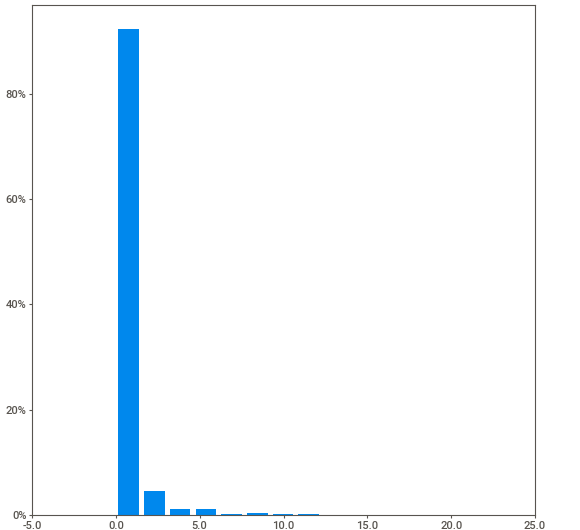
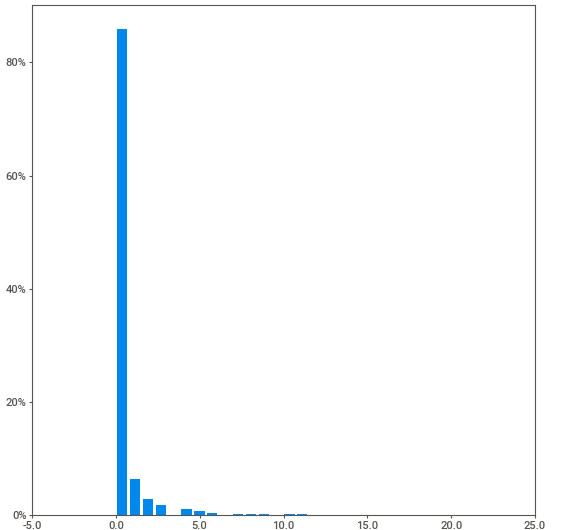
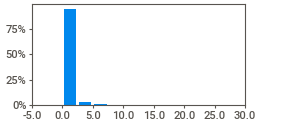
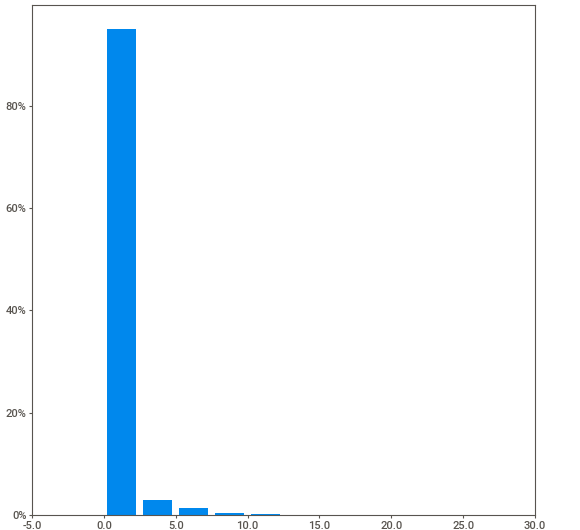
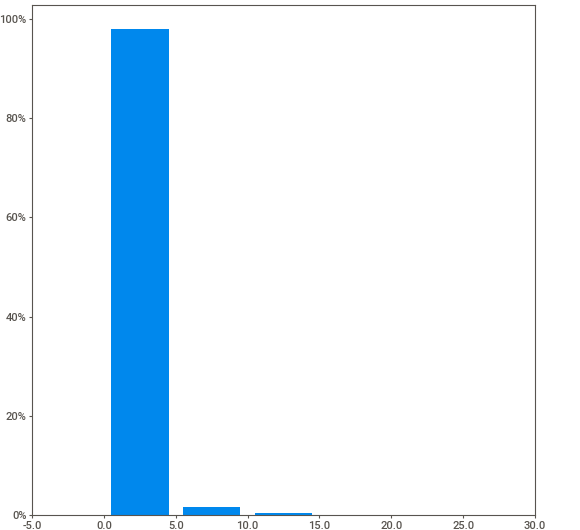
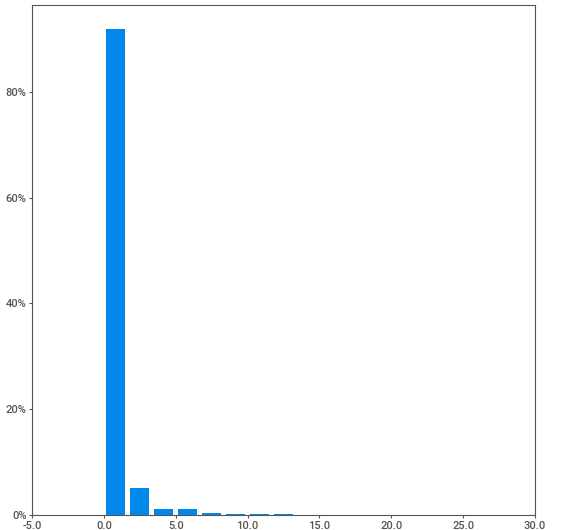
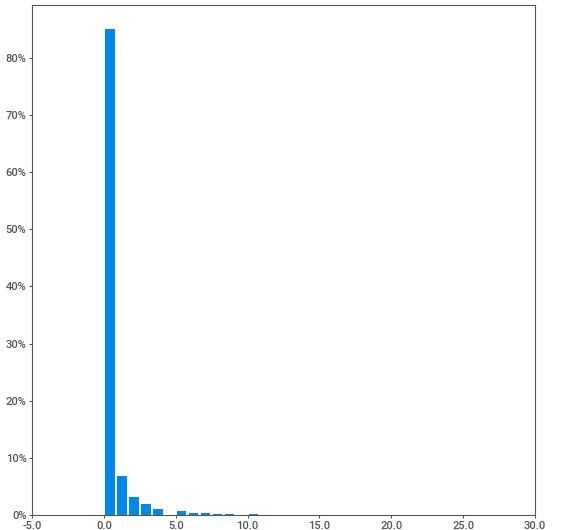
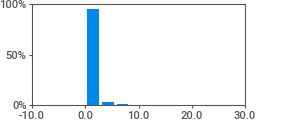
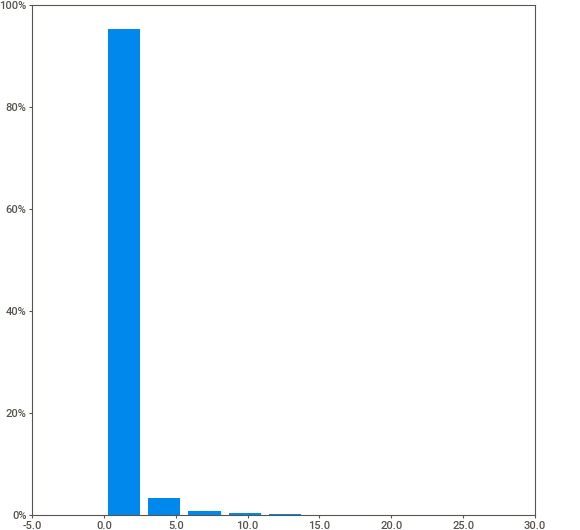
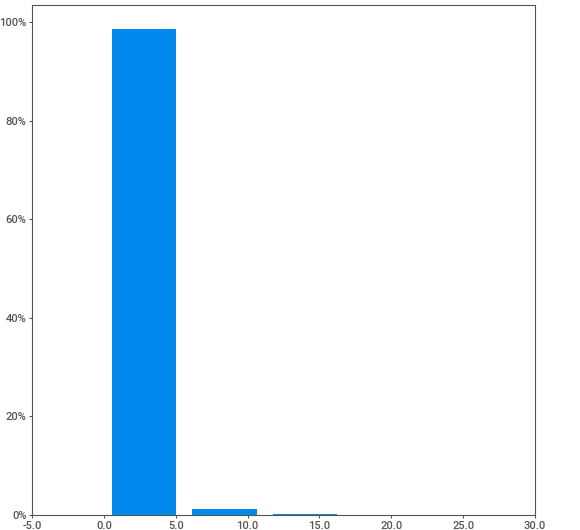
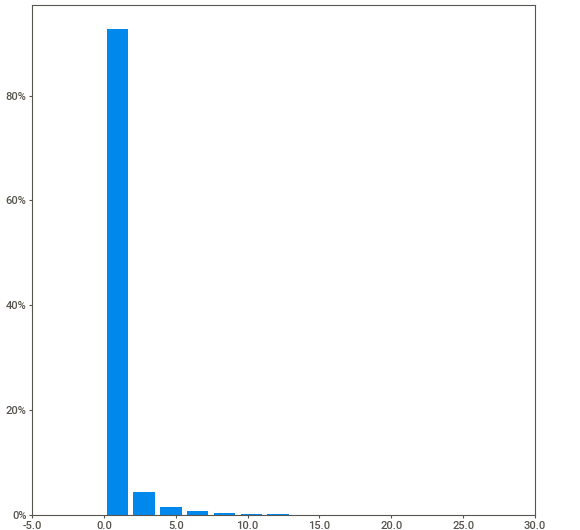
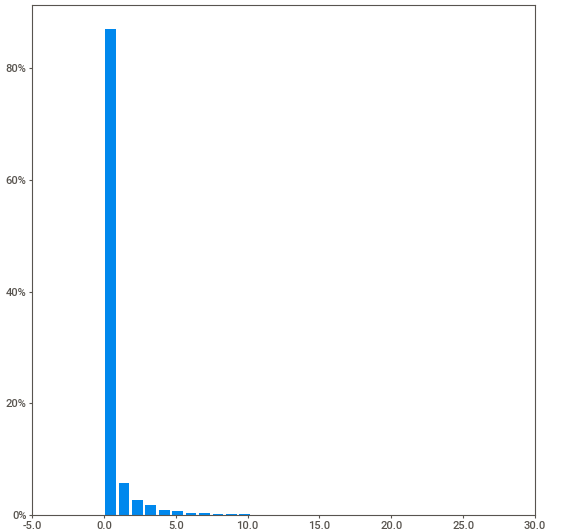
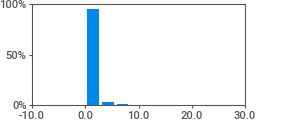
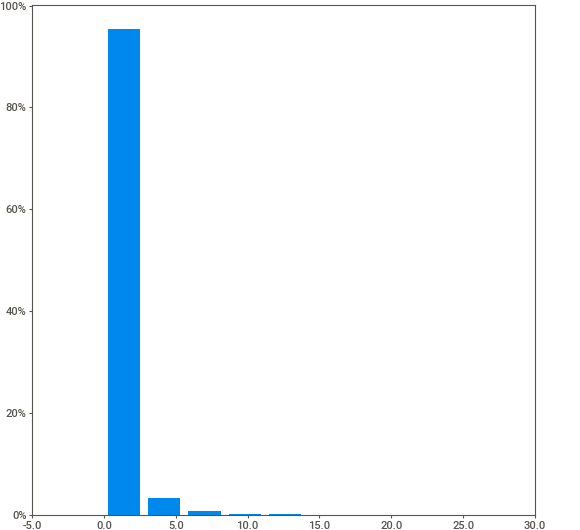
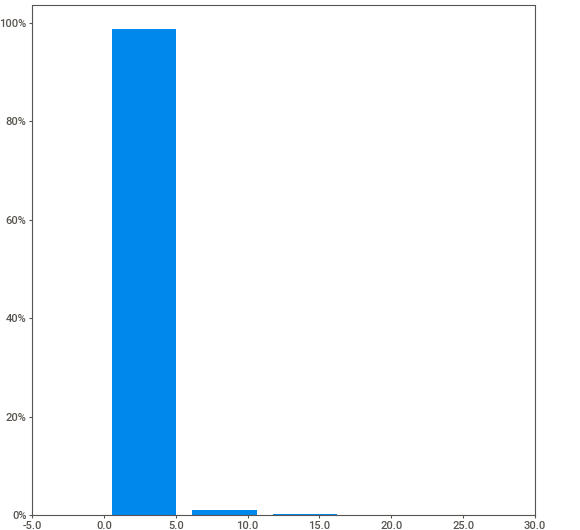
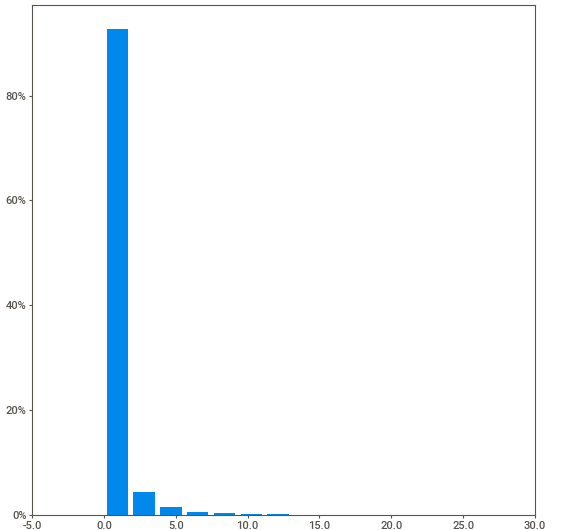
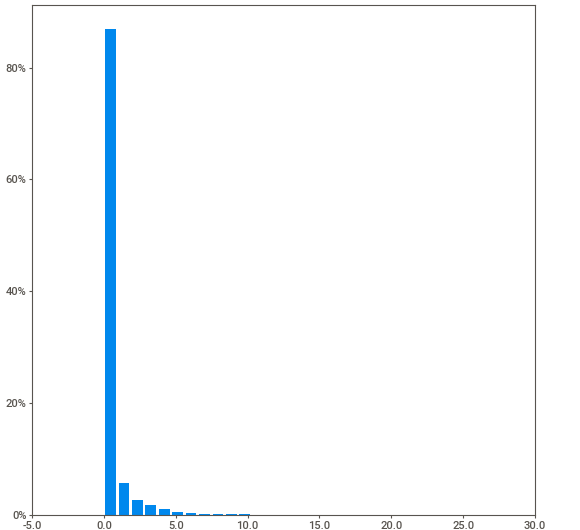
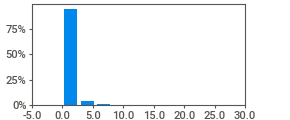
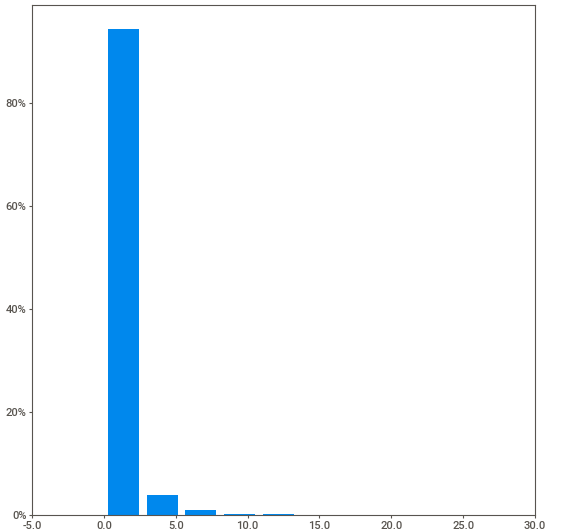
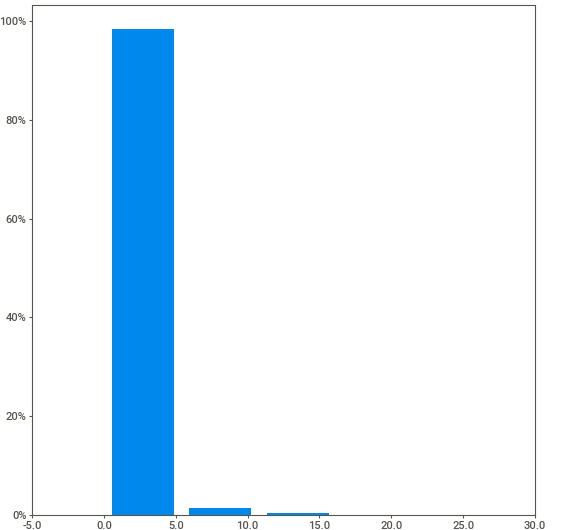
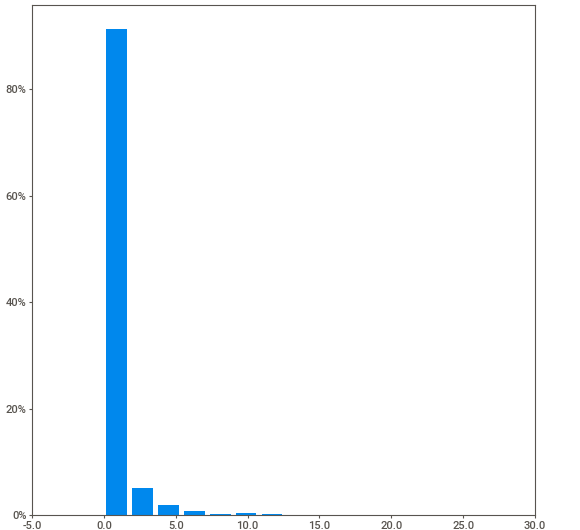
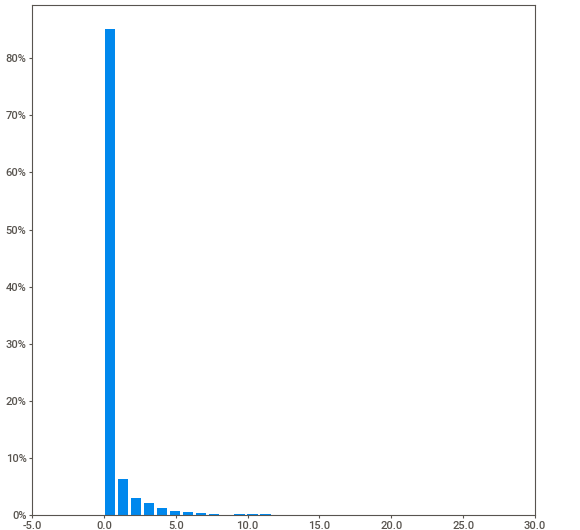
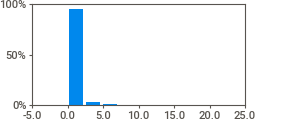
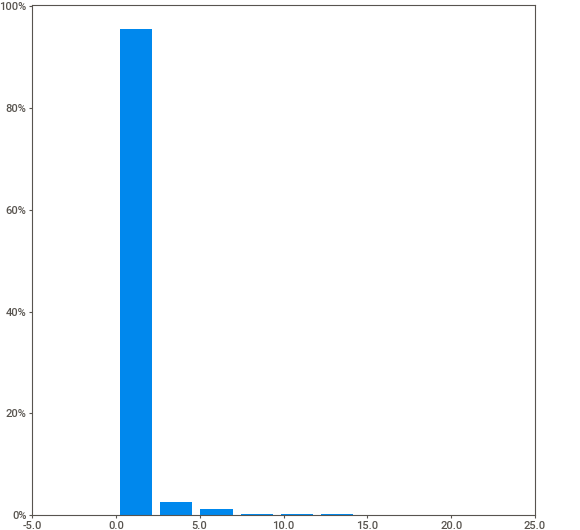
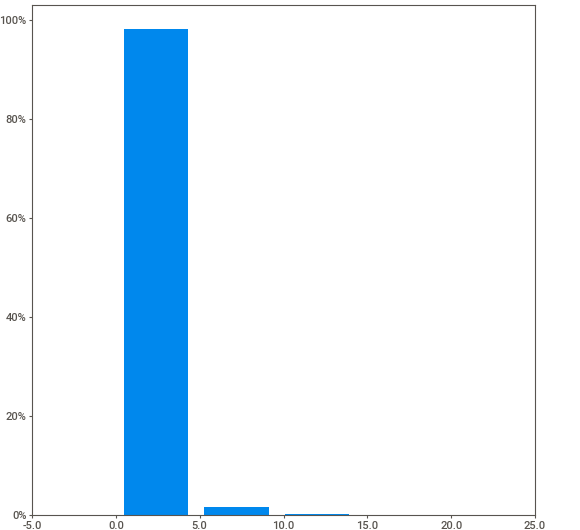
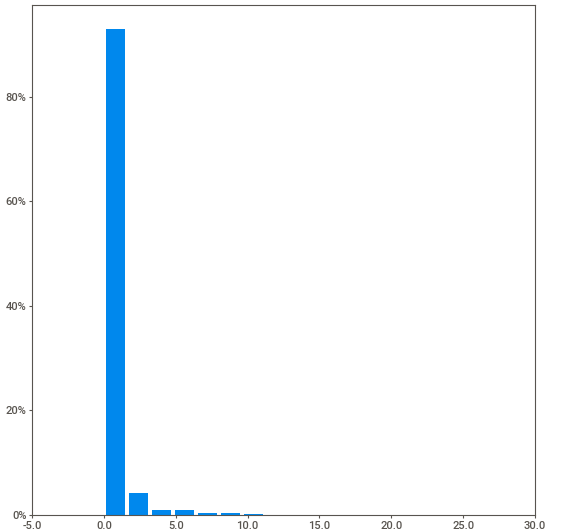
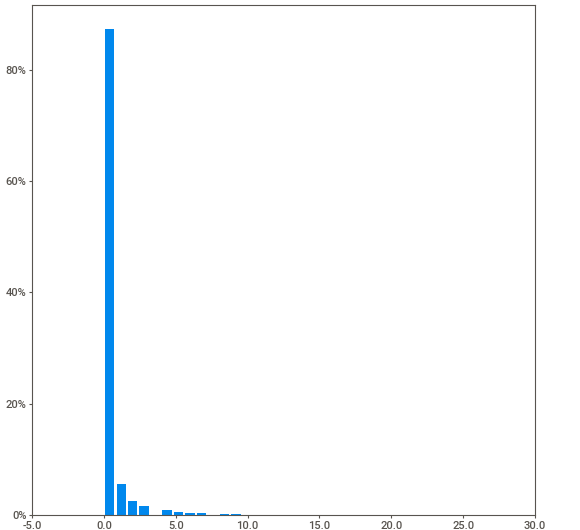
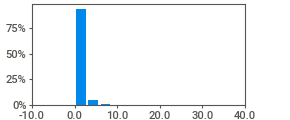
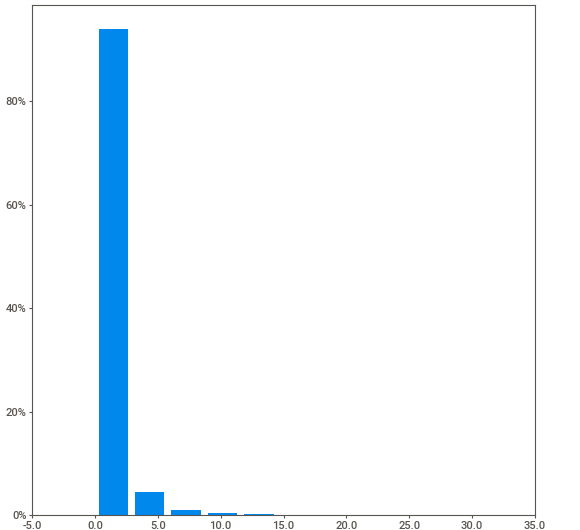
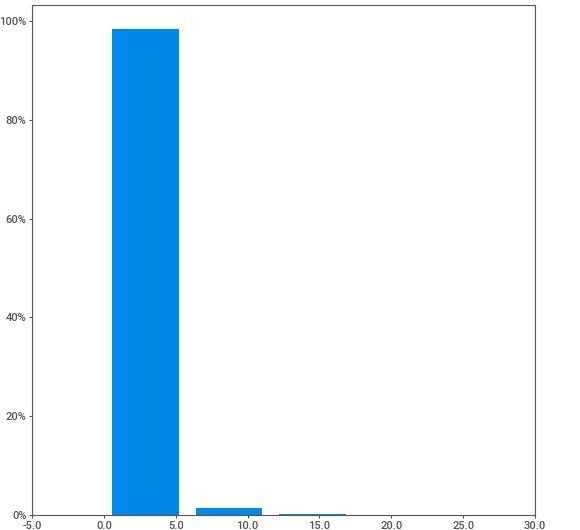
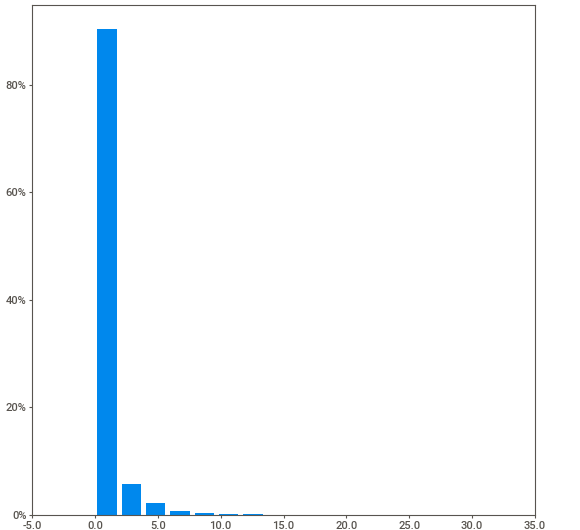
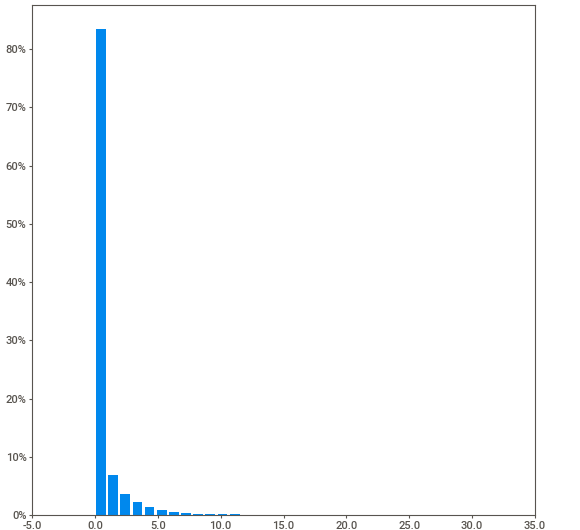
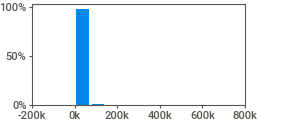
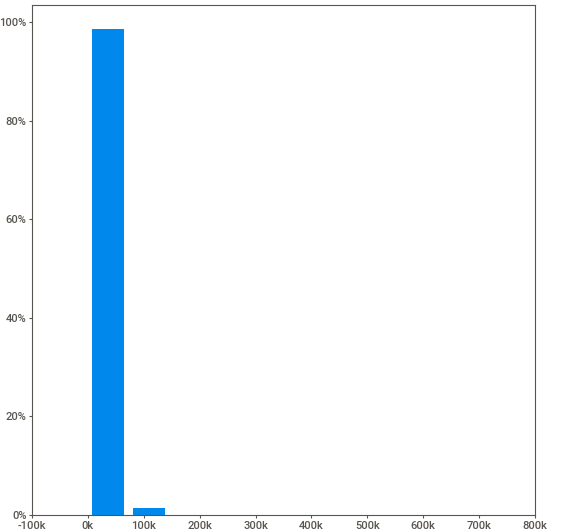
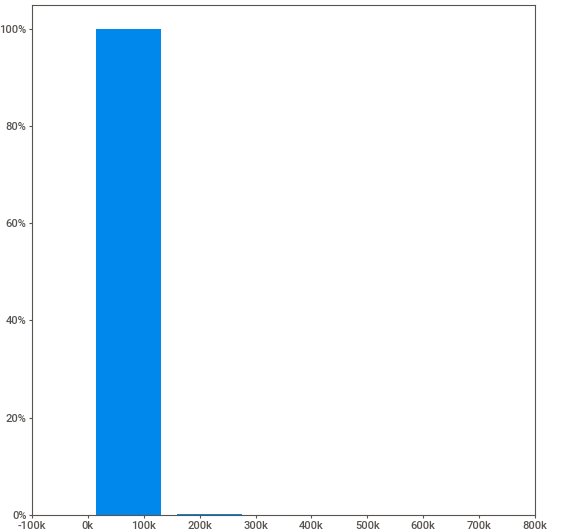
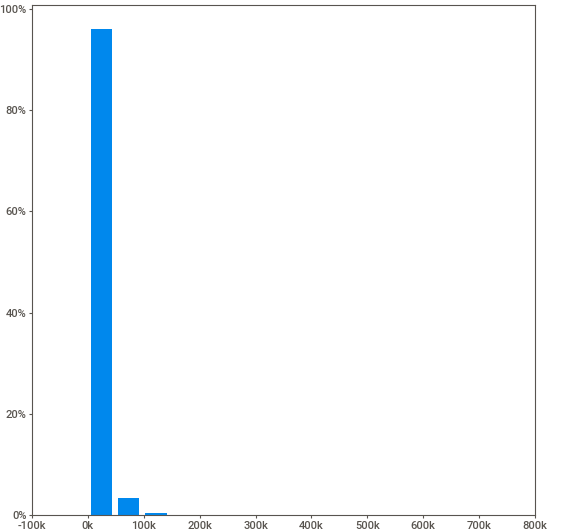
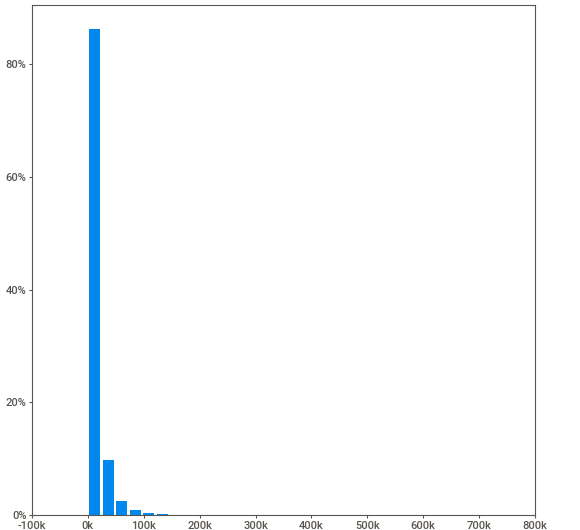
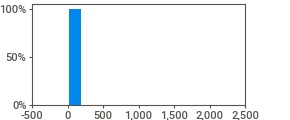
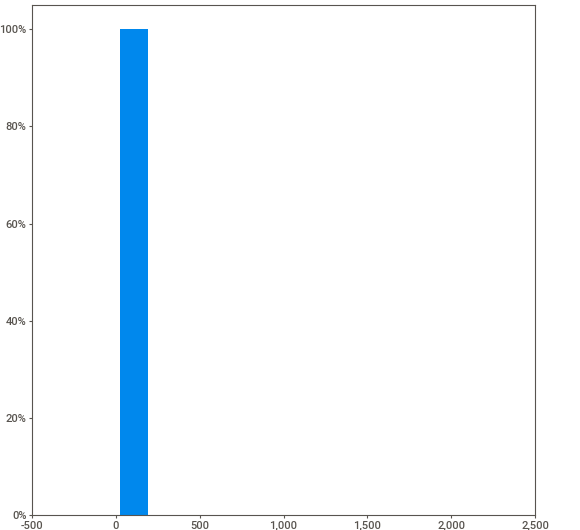
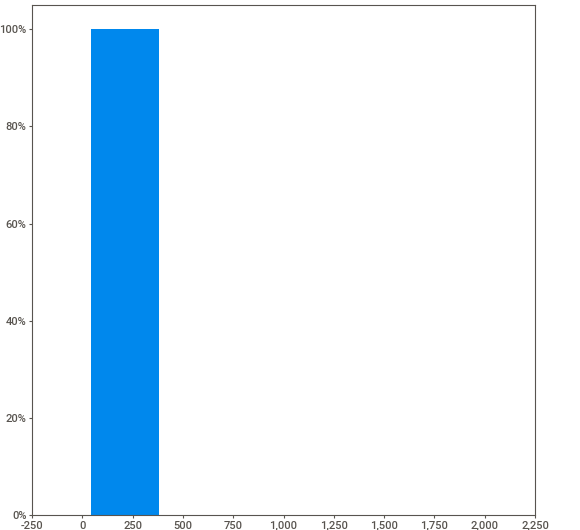
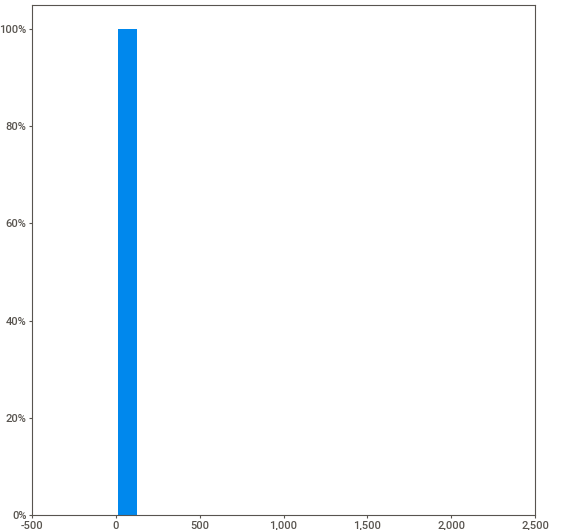
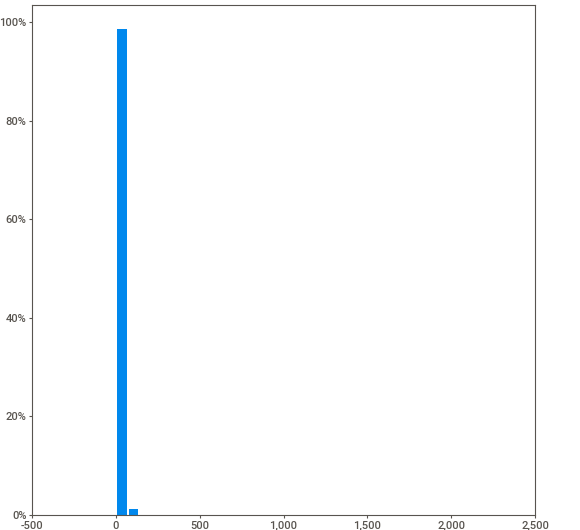
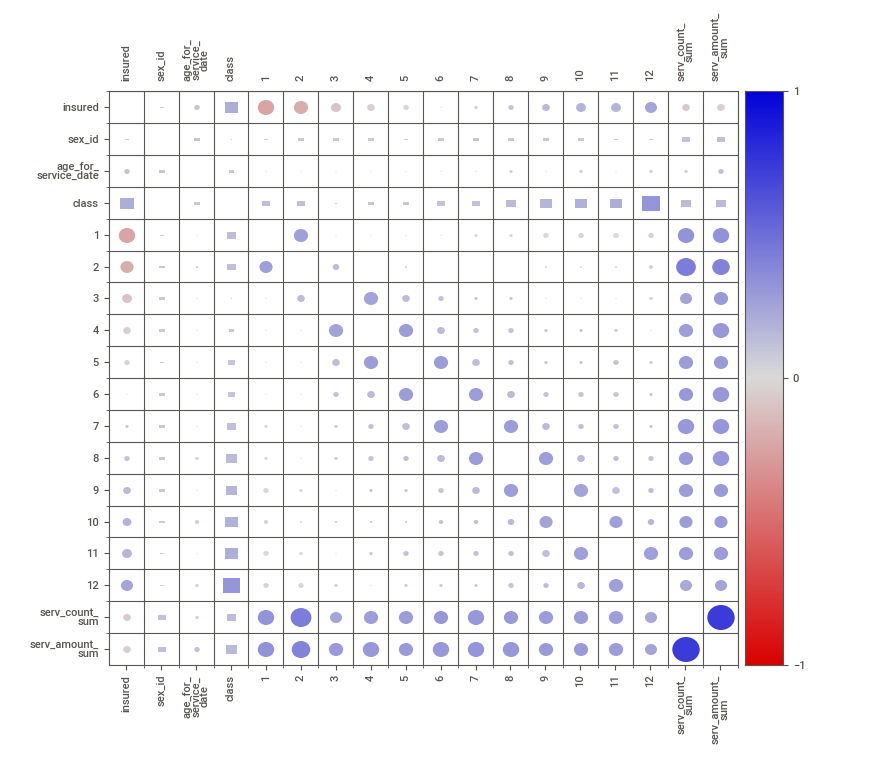
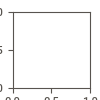

In [ ]:
sv.analyze(full).show_notebook()

In [ ]:
#Доля объектов положительного класса:
sum(full["class"])/len(full)

0.09265073462171554

In [ ]:
#Доля объектов отрицательного класса:
1 - sum(full["class"])/len(full)

0.9073492653782844

Виден явный дисбаланс классов в пользу отрицательного класса. Если мы будем всех людей прогнозировать, что они не обратятся, то в 90% случаев мы будем правы. Отношение 1 к 10

## 3 Исследование задачи

In [ ]:
#Разделим объекты и целевой признак
features = full.drop("class", axis=1)
target = full["class"]

Т.к. у нас один датасет, то делить его будем на 3 части: обучаемая(60%), валидационная (20%) и тестовая (20%)

In [ ]:
x, features_test, y, target_test = train_test_split(features, target, test_size=0.2, train_size=0.8)

In [ ]:
#Отделения валидационной и обучающей выборки
features_train, features_valid, target_train, target_valid = train_test_split(x, y, test_size = 0.25, train_size =0.75)

In [ ]:
#Скалирование
scaler = StandardScaler()
scaler.fit(features_train) 
features_train_scaled = scaler.transform(features_train)
features_valid_scaled = scaler.transform(features_valid)
features_test_scaled = scaler.transform(features_test)

In [ ]:
#Преобразуем nparray в dataframe
def nptodf(data, ind, column):
    frame = pd.DataFrame(data, index = ind.index, columns = column.columns)
    return frame
features_train_scaled = nptodf(features_train_scaled, target_train, features)
features_valid_scaled = nptodf(features_valid_scaled, target_valid, features)
features_test_scaled = nptodf(features_test_scaled, target_test, features)

In [ ]:
#Проверка разделения
def check(data):
    res = len(data)/len(full)
    print('Процент выборки:', res, ', Количество строк и столбцов:', data.shape)
    
data_list = [features_train_scaled, target_train, features_valid_scaled, target_valid, features_test_scaled, target_test]
for i in data_list:
    check(i)

Процент выборки: 0.599996951777114 , Количество строк и столбцов: (78734, 17)
Процент выборки: 0.599996951777114 , Количество строк и столбцов: (78734,)
Процент выборки: 0.20000152411144304 , Количество строк и столбцов: (26245, 17)
Процент выборки: 0.20000152411144304 , Количество строк и столбцов: (26245,)
Процент выборки: 0.20000152411144304 , Количество строк и столбцов: (26245, 17)
Процент выборки: 0.20000152411144304 , Количество строк и столбцов: (26245,)


In [ ]:
#Функция построения важности признаков
def impnt(imp):
    importances = pd.DataFrame(data={
          'Attribute': features_train_scaled.columns,
          'Importance':imp
      })
    importances = importances.sort_values(by='Importance', ascending=False)
    plt.figure(figsize = (12,6))
    sns.barplot(x=importances['Attribute'], y=importances['Importance'], color='#087E8B')
    plt.title('Важность признаков', size=20)
    plt.xticks(rotation='vertical')
    plt.xlabel('Признак')
    plt.ylabel('Важность')
    plt.show();

### 3.1 Дерево решений

In [ ]:
param_grid_dt = {'criterion': ['gini', 'entropy'],
                'max_depth': [None, 2, 3, 4, 5, 6],
                'min_samples_split': [2, 5, 10],
                'min_samples_leaf': [1, 2, 3, 4, 5, 6]
             }

In [ ]:
dtc_model = DecisionTreeClassifier(random_state = 12345,class_weight = "balanced")

In [ ]:
grid_dt = GridSearchCV(dtc_model, param_grid=param_grid_dt, verbose=True)
grid_dt.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits


GridSearchCV(estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 3, 4, 5, 6],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6],
                         'min_samples_split': [2, 5, 10]},
             verbose=True)

In [ ]:
predictions_dt = grid_dt.predict(features_valid_scaled)
result_dt = accuracy_score(target_valid, predictions_dt)
result_f1_dt = f1_score(predictions_dt, target_valid)
print('F1 мера дерево решений:', result_f1_dt)
print("Лучший результат:", result_dt, end='') 

F1 мера дерево решений: 0.24274840567784406
Лучший результат: 0.8597447132787197

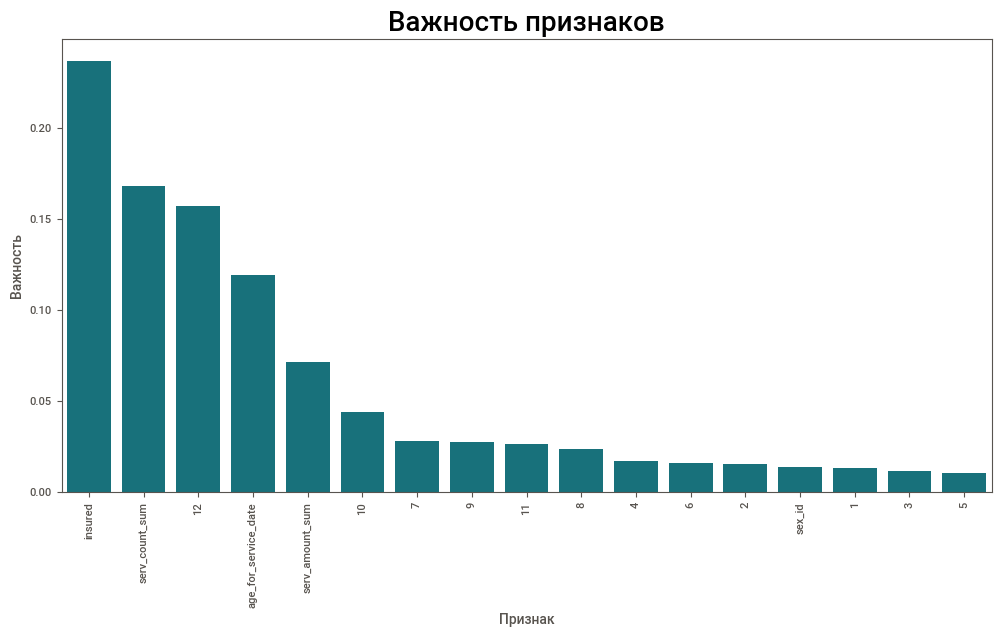

In [ ]:
impnt(grid_dt.best_estimator_.feature_importances_)

### 3.2 Случайный лес

In [ ]:
model_rf = RandomForestClassifier(random_state = 12345, class_weight = "balanced")

In [ ]:
param_grid_rf = {'n_estimators': [10, 30],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 2, 6, 10],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [3, 6],
                'bootstrap': [True, False]
}

In [ ]:
grid_rf = GridSearchCV(model_rf, param_grid=param_grid_rf, verbose=True)
grid_rf.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 128 candidates, totalling 640 fits


GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=12345),
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 2, 6, 10],
                         'min_samples_leaf': [3, 6],
                         'min_samples_split': [5, 10],
                         'n_estimators': [10, 30]},
             verbose=True)

In [ ]:
predictions_rf = grid_rf.predict(features_valid_scaled)
result_rf = accuracy_score(target_valid, predictions_rf)
result_f1_rf = f1_score(predictions_rf, target_valid)
print('F1 мера случайный лес:', result_f1_rf)
print("Лучший результат:", result_rf, end='') 

F1 мера случайный лес: 0.34644351464435147
Лучший результат: 0.8809678033911221

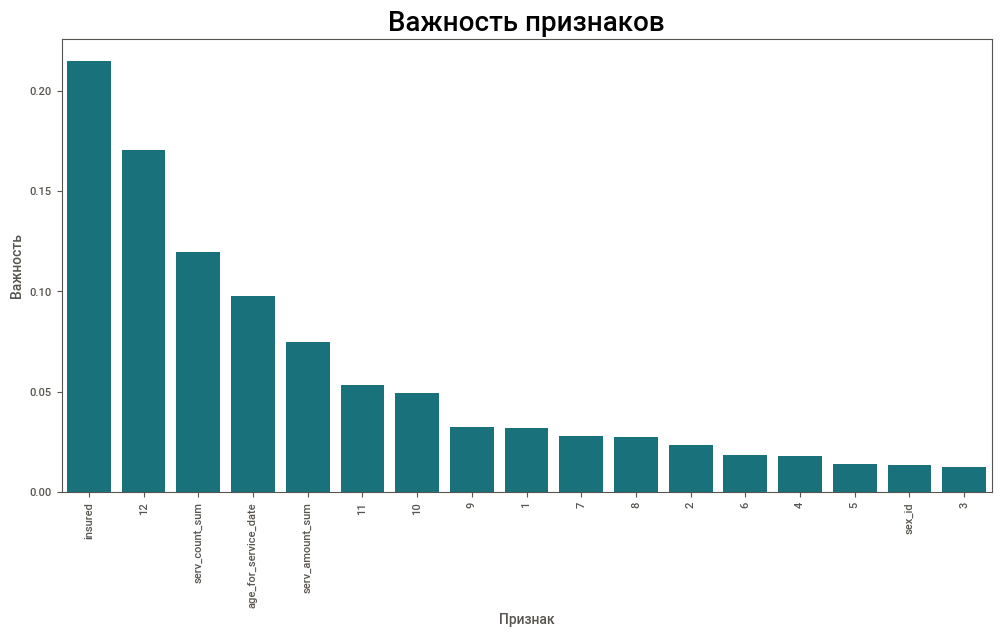

In [ ]:
impnt(grid_rf.best_estimator_.feature_importances_)

### 3.3 Логистическая регрессия


In [ ]:
lr_model = LogisticRegression(random_state = 12345, solver='liblinear', class_weight = 'balanced')

In [ ]:
param_grid_lr = {'C': np.logspace(-4, 4, 50),
'penalty': ['l1', 'l2']}

In [ ]:
grid_lr = GridSearchCV(lr_model, param_grid=param_grid_lr, verbose=True)
grid_lr.fit(features_train_scaled, target_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


GridSearchCV(estimator=LogisticRegression(class_weight='balanced',
                                          random_state=12345,
                                          solver='liblinear'),
             param_grid={'C': array([1.00000000e-04, 1.45634848e-04, 2.12095089e-04, 3.08884360e-04,
       4.49843267e-04, 6.55128557e-04, 9.54095476e-04, 1.38949549e-03,
       2.02358965e-03, 2.94705170e-03, 4.29193426e-03, 6.25055193e-03,
       9.10298178e-03, 1.32571137e-02, 1.93069773e-...
       3.72759372e+00, 5.42867544e+00, 7.90604321e+00, 1.15139540e+01,
       1.67683294e+01, 2.44205309e+01, 3.55648031e+01, 5.17947468e+01,
       7.54312006e+01, 1.09854114e+02, 1.59985872e+02, 2.32995181e+02,
       3.39322177e+02, 4.94171336e+02, 7.19685673e+02, 1.04811313e+03,
       1.52641797e+03, 2.22299648e+03, 3.23745754e+03, 4.71486636e+03,
       6.86648845e+03, 1.00000000e+04]),
                         'penalty': ['l1', 'l2']},
             verbose=True)

In [ ]:
predictions_lr = grid_lr.predict(features_valid_scaled)
result_lr = accuracy_score(target_valid, predictions_lr)
result_f1_lr = f1_score(predictions_lr, target_valid)
print('F1 мера Логистическая регрессия:', result_f1_lr)
print("Лучший результат:", result_lr, end='') 

F1 мера Логистическая регрессия: 0.3784907902554962
Лучший результат: 0.8405791579348447

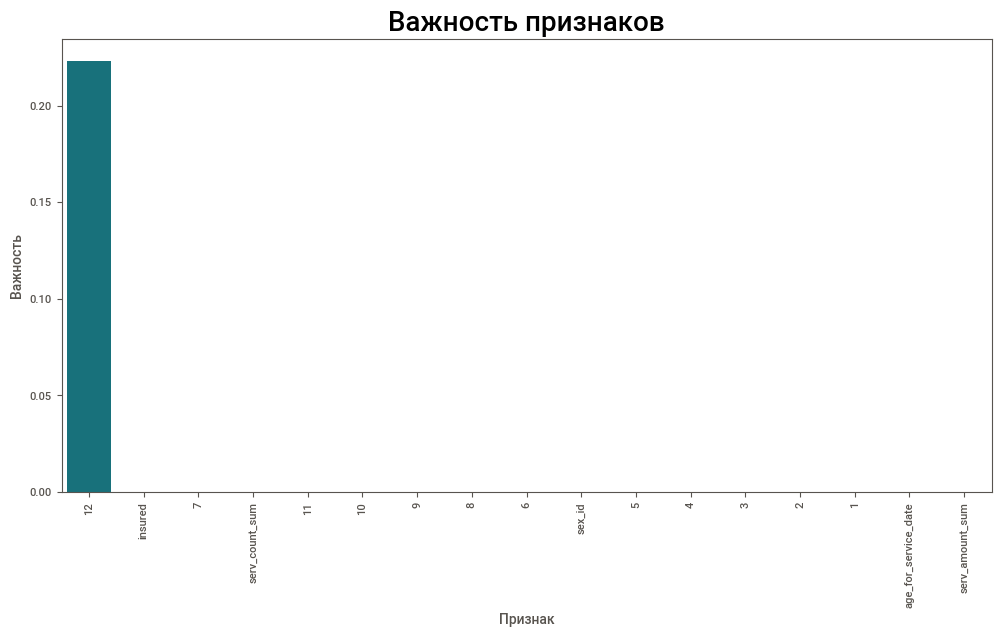

In [ ]:
impnt(grid_lr.best_estimator_.coef_[0])

Так как лучшие результаты показала модель случайного леса, будем работать с ней

### 3.4 Вывод
Лучший результат по точности у случайного леса, по f1-мере у логистической регрессии

## 4 Борьба с дисбалансом

### 4.1 Upsampling

In [ ]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

In [ ]:
features_upsampled, target_upsampled = upsample(features_train_scaled, target_train, 10)

In [ ]:
target_upsampled.value_counts()

1    72880
0    71446
Name: class, dtype: int64

In [ ]:
model_rf_up = RandomForestClassifier(random_state = 12345)

In [ ]:
param_grid_rf_up = {'n_estimators': [10, 30],
                'criterion': ['gini', 'entropy'],
                'max_depth': [None, 2, 6, 10],
                'min_samples_split': [5, 10],
                'min_samples_leaf': [3, 6],
                'bootstrap': [True, False]
}

In [ ]:
grid_rf_up = GridSearchCV(model_rf_up, param_grid=param_grid_rf_up, verbose=2)

In [ ]:
grid_rf_up.fit(features_upsampled, target_upsampled)

In [ ]:
predictions_rf_up = grid_rf_up.predict(features_valid_scaled)
result_f1_rf = f1_score(target_valid, predictions_rf_up)
result_rf = grid_rf_up.score(features_valid_scaled, target_valid)
print('F1 мера случайный лес:', result_f1_rf)
print("Лучший результат:", result_rf, end='')

F1 мера случайный лес: 0.2978520286396181
Лучший результат: 0.8879024576109735

### 4.2 Downsampling

In [ ]:
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    
    return features_downsampled, target_downsampled

In [ ]:
features_downsampled_train, target_downsampled_train = downsample(features_train_scaled, target_train, fraction=0.1)

In [ ]:
target_downsampled_train.value_counts()

1    7288
0    7145
Name: class, dtype: int64

In [ ]:
param_grid_rf_down = {'max_depth': [None, 2, 6, 10],
              'n_estimators':[10, 30],
              'criterion': ['gini', 'entropy'],
              'min_samples_leaf':[6, 8],
              'min_samples_split':[6, 8],
              'bootstrap': [True, False]
           }

In [ ]:
grid_rf_down = GridSearchCV(model_rf_up, param_grid=param_grid_rf_down, verbose=2)

In [ ]:
grid_rf_down.fit(features_downsampled_train, target_downsampled_train)

In [ ]:
predictions_rf_down = grid_rf_down.predict(features_valid_scaled)
result_f1_down = f1_score(target_valid, predictions_rf_down)
result_rf_down = grid_rf_down.score(features_valid_scaled, target_valid)
print('F1 мера случайный лес:', result_f1_down)
print("Лучший результат:", result_rf_down, end='')

F1 мера случайный лес: 0.34632965851035225
Лучший результат: 0.7221184987616689

Лучшие результаты после upsampling

### 4.3 ROC-AUC

In [ ]:
def roc(model): 
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    fpr, tpr, thresholds = roc_curve(target_valid, probabilities_one_valid)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show() 
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print(auc_roc)

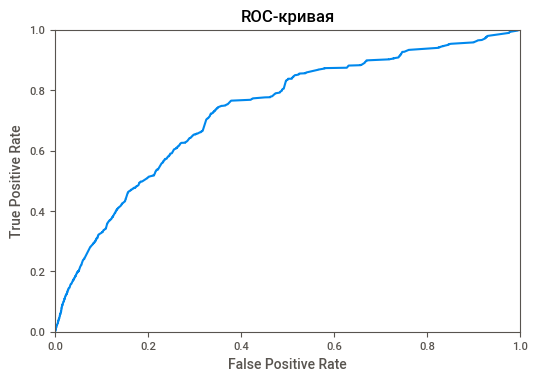

0.7319209317442268


In [ ]:
roc(grid_rf_up)

### 4.4 Выводы

- Модель случайного леса до борьбы с дисбалансом показывала результат метрики f1 ~3.4%, точности ~ 88%
- Произвели upsampling положительного класса, благодаря чему удалось повысить точность до ~ 88.8%


## 5 Тестирование модели и её метрики

In [ ]:
predictions_test = grid_rf_up.predict(features_test_scaled)
print("Accuracy:", accuracy_score(target_test, predictions_test))
print("F1:", f1_score(target_test, predictions_test))
print("Precision:", precision_score(target_test, predictions_test))
print("Recall:", recall_score(target_test, predictions_test))

Accuracy: 0.8851971804153173
F1: 0.2955342529810615
Precision: 0.3528754885538805
Recall: 0.25422365245374096


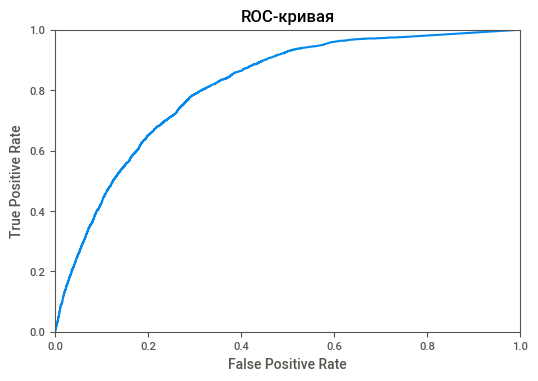

Показатели roc auc: 0.8106283863400775


In [ ]:
probabilities_test = grid_rf_up.predict_proba(features_test_scaled)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(target_test, probabilities_one_test)
plt.figure()
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(target_test, probabilities_one_test)
print('Показатели roc auc:', auc_roc)

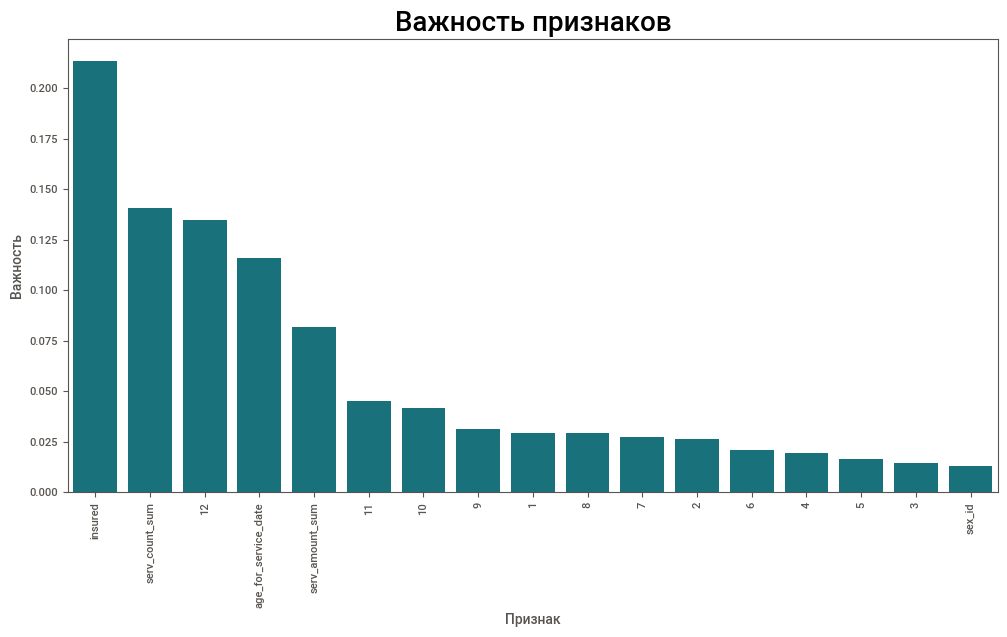

In [ ]:
impnt(grid_rf_up.best_estimator_.feature_importances_)

In [ ]:
importances = pd.DataFrame(data={
          'Attribute': features_test_scaled.columns,
          'Importance':grid_rf_up.best_estimator_.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)

In [ ]:
importances.to_csv('importances.csv', index=False, sep = ';')

In [ ]:
tocsv = target_test.reset_index()

In [ ]:
tocsv['pred'] = predictions_test

In [ ]:
tocsv.to_csv('task.csv', index=False, sep = ';')

In [ ]:
metrics = pd.DataFrame({'Accuracy': accuracy_score(target_test, predictions_test), 
                    'F1': f1_score(target_test, predictions_test),
                    'Precision' : precision_score(target_test, predictions_test),
                    'Recall' : [recall_score(target_test, predictions_test)],
                    'ROC_AUC' : roc_auc_score(target_test, probabilities_one_test)})


In [ ]:
metrics.to_csv("metrics.txt", index=None, sep=',', mode='w')

### 5.1 Вывод

- Был проведен первичный анализ данных, выявлен явный дисбаланс классов, отрицательного к положительному - 10 к 1.
- Произвели предобработку данных, удалили дупликаты, прошкалировали количественные переменные.
- Произвели upsampling положительного класса, благодаря чему удалось повысить точность до ~ 88.8%.
- Проверка на тестовой выборке показывает:</br>
    Accuracy: 0.8851971804153173</br>
    F1: 0.2955342529810615</br>
    Precision: 0.3528754885538805</br>
    Recall: 0.25422365245374096